In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

In [2]:
df=pd.read_csv(r"C:\Users\SAURABH UPADHYAY\Malignant\train.csv")

test=pd.read_csv(r"C:\Users\SAURABH UPADHYAY\Malignant\test.csv")

In [3]:
df.head(7)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [4]:
test.head(7)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...


In [5]:
print("In the training dataset\nNumber of columns=",df.shape[1],'\nNumber of Rows=',df.shape[0],\
      '\nName of columns=\n',df.columns.values)

In the training dataset
Number of columns= 8 
Number of Rows= 159571 
Name of columns=
 ['id' 'comment_text' 'malignant' 'highly_malignant' 'rude' 'threat'
 'abuse' 'loathe']


In [6]:
print("In the test dataset\nNumber of columns=",test.shape[1],'\nNumber of Rows=',test.shape[0],\
      '\nName of columns=\n',test.columns.values)

In the test dataset
Number of columns= 2 
Number of Rows= 153164 
Name of columns=
 ['id' 'comment_text']


In [7]:
#checking if there is any duplicated values in training dataset
print('Number of duplicated values:-',df.duplicated().sum())

Number of duplicated values:- 0


In [8]:
#checking if there is any duplicated values in test dataset
print('Number of duplicated values:-',test.duplicated().sum())

Number of duplicated values:- 0


In [9]:
#checking for null values in training dataset
for i in df.columns:
    null=df[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'
There are no null values in  'malignant'
There are no null values in  'highly_malignant'
There are no null values in  'rude'
There are no null values in  'threat'
There are no null values in  'abuse'
There are no null values in  'loathe'


In [10]:
#checking for null values in test dataset
for i in test.columns:
    null=test[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'


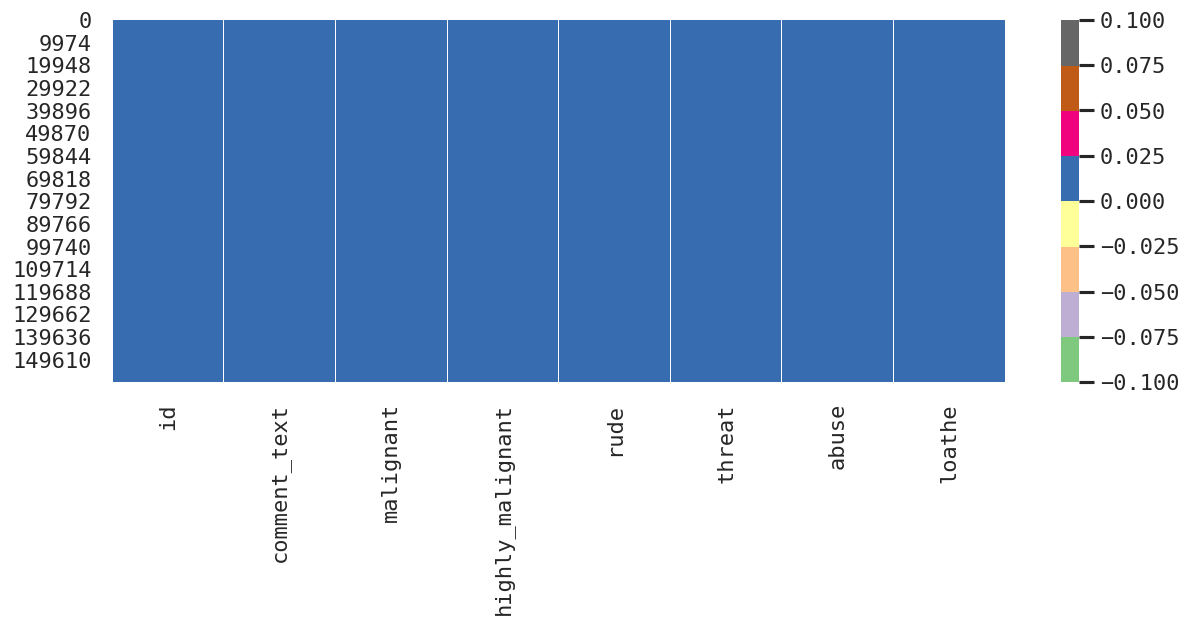

In [11]:
#heatmap of null values
sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.8)
plt.figure(figsize=(12,4),dpi=120)
sns.heatmap(df.isnull(),cmap='Accent')
plt.show()

In [12]:
#dropping unwanted columns as we'll be working on the comment_text and their categories_
cmt=df.copy()
cmt.drop(['id'],axis=1,inplace=True)

In [13]:
test.drop(['id'],axis=1,inplace=True)

In [14]:
#adding a new column which represent a normal statement

labels= ['malignant','highly_malignant','rude','threat','abuse','loathe']
cmt['normal']=1-cmt[labels].max(axis=1)

In [15]:
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0


```The column named 'normal' represents the columns which are not falling under 'malignant','highly_malignant','rude','threat','abuse','loathe' categories```

In [16]:
#adding a column 'raw length' to the dataset which will show the length of characters in column 'comment_text'
cmt['raw length']= cmt.comment_text.str.len().astype('int64')
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44


In [17]:
#value counts of  label columns
values=['malignant','highly_malignant','rude','threat','abuse','loathe']
for i in values:
    vc=cmt[i].value_counts()
    print('VALUE COUNT OF UNIQUE VALUES IN ' +"'"+ i+"' :\n ",vc,'\n')

VALUE COUNT OF UNIQUE VALUES IN 'malignant' :
  0    144277
1     15294
Name: malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'highly_malignant' :
  0    157976
1      1595
Name: highly_malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'rude' :
  0    151122
1      8449
Name: rude, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'threat' :
  0    159093
1       478
Name: threat, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'abuse' :
  0    151694
1      7877
Name: abuse, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'loathe' :
  0    158166
1      1405
Name: loathe, dtype: int64 



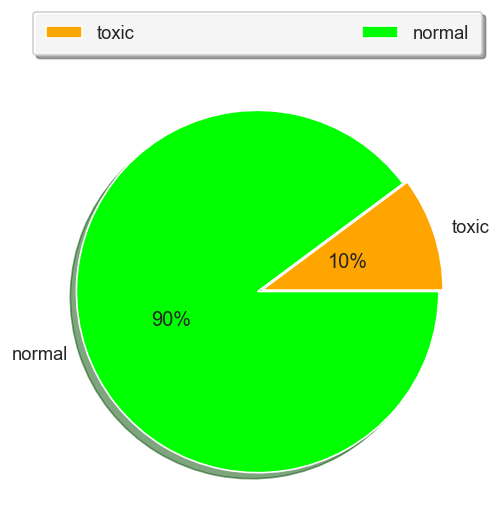

In [18]:
#Pie plot to show the percentage of toxic and normal comment
values=[cmt.shape[0]-cmt.normal.sum(),cmt.normal.sum()]
label=['toxic','normal']
exp=(0.025,0)
clr=('orange','lime')
plt.figure(figsize=(5,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=values,explode=exp,labels=label,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=1)
plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102),ncol=2, mode="expand", borderaxespad=0.1)
plt.show()

In [19]:
#COUNT OF DIFFERENT LABELS
x=cmt.iloc[:,2:-1].sum()
x

highly_malignant      1595
rude                  8449
threat                 478
abuse                 7877
loathe                1405
normal              143346
dtype: int64

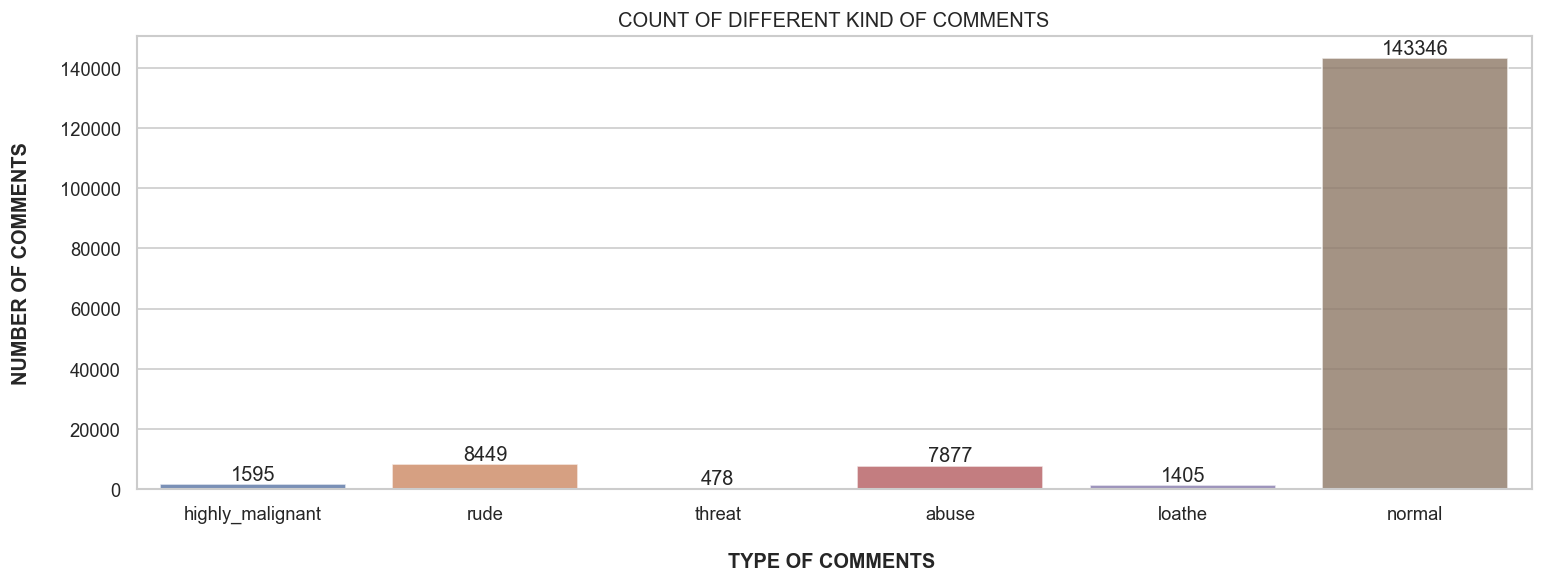

In [20]:
#COUNT OF LABELS
x=cmt.iloc[:,2:-1].sum() #not including comment_text and raw length column
plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("COUNT OF DIFFERENT KIND OF COMMENTS")
plt.ylabel('NUMBER OF COMMENTS\n', fontsize=12,weight='bold')
plt.xlabel('\nTYPE OF COMMENTS ', fontsize=12,weight='bold')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [21]:
#CHECKING THE COUNT OF COMMENTS WITH 1 OR MORE THAN 1 LABELS
summation=cmt.iloc[:,2:-1].sum(axis=1) #not including comment_text and raw length column
vc=summation.value_counts()
vc

1    147303
0      5666
2      4406
3      1780
4       385
5        31
dtype: int64

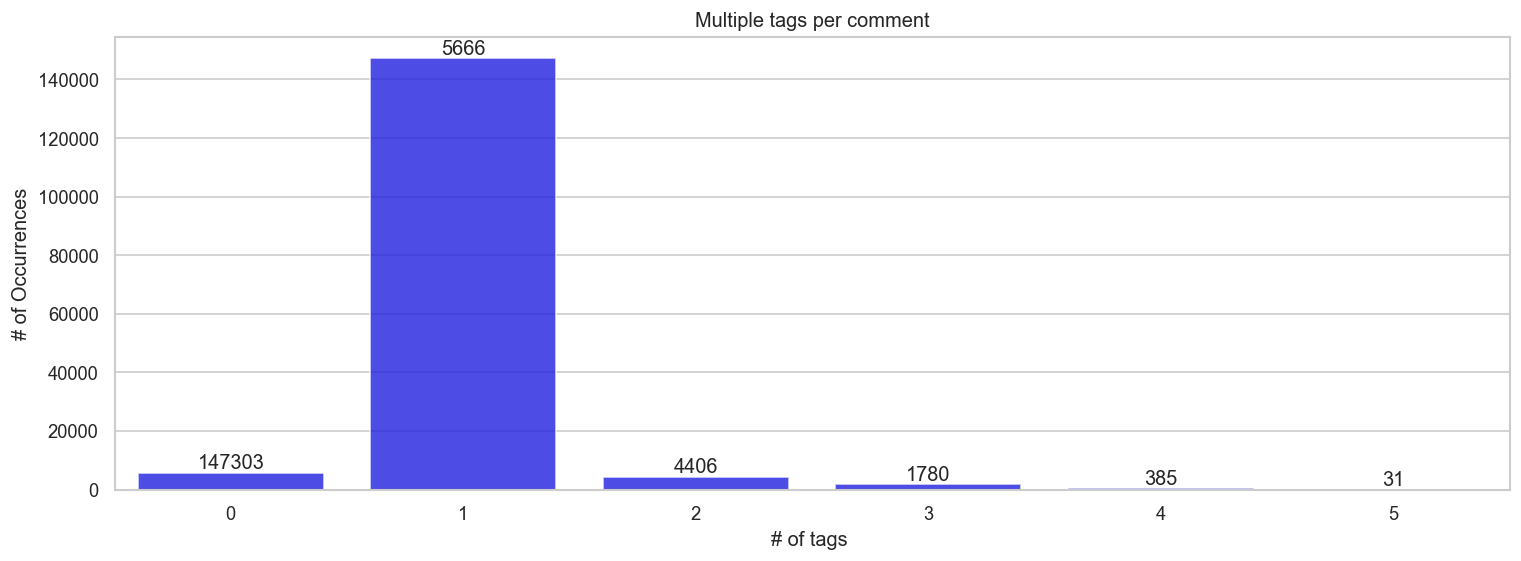

In [22]:
#PLOTTING NUMBERS OF COMMENTS WITH 1 OR MORE THAN 1 LABELS

plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax=sns.barplot(x=vc.index, y=vc.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
rects = ax.patches
labels = vc.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [23]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
 7   normal            159571 non-null  int64 
 8   raw length        159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [25]:
cmt.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321,394.138847
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226,590.725381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,436.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


In [26]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'yo','nothin','from','bein','u','ok','yup','youve',
           'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','ur','mlm','nbfc',"he's",'ip','ja',"there's",'tyme','yep',\
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','lol','lool','fwiw','argh',"dont","i'll",'utc','too','y','u','r',\
           'doesnt','who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','oh','hay','thanks','ty','wc','ha','hi','d','re',\
           'll','there','someone','say','be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','even','aww','bye!','bye','e',\
           'f','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after',\
           'above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how',\
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','\
           don',"don't",'should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",\
           'hadn', "hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",\
           'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'looked', "what's",'although','upright','bit',\
           'right','state',"i've",'much','more',"there's","You've",'got',"i'd",'everything','true','yes','moreover','would','could','like','mr.','but',"i'm",'able',\
           'back','get','still','ought','perhaps','without','away','onto','ive','let','must','see','went','saw','many','whats','id','let','day','never','yet','im','go',\
           'thatll','theyre','came','youll','come','word','noone',"mrs.","now!","then?",'mr','ve','Â Â','january','days','february','march','april','may',\
           'june','july','august','september','october','november','december','everyone','hey','ok','okay','cant','bbq','let','thats','also','time','name',\
           'oh', 'said','asked','anyone','however','wow','daww']

print(len(stopwords))

322


In [27]:
#CREATING A FUNCTION TO PERFORM ASERIES OF OPERATIONS

def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    #converting to lower case and replacing mail id,links by white space
    
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    #removing \n,large white space and leading_trailing white spaces, numbers by white space
    
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    #removing special characters by single white space
    
   
   
    punct=text.translate(str.maketrans('', '', p))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', d))       #remove digits if any
    word= wt(digit, "english")
    
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
           # lemma=wl().lemmatize(i)
            #stem=porter.stem(lemma)
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [28]:
#TESTING THE FUNCTION CREATED ABOVE
sample=" As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable information\
on the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - \
are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the \
Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing the\
line a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters \
Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on \
wiki to ""Country where the Rohingya are Persecuted"".\nRather, a brief mention of where the Rohingyas reside should be placed if desired\
on the main article on Rakhine state - albeit short and concise, not dump an entire list of names copied directly from some publication.\nWith\
all due respect, this article should be deleted."
print("Original Document: \n",sample)

processed=[]
for word in sample.split(' '):
    processed.append(word)
print('\n',processed)
print("\n\nTokenized and lemmatized document: \n")
print(preprocess(sample))

Original Document: 
  As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable informationon the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing theline a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on wiki to Country where the Rohingya are Persecuted.
Rather, a brief mention of where the Rohingyas reside should be placed if desiredon the main article on Rakhine state - albeit short and conc

In [29]:
%%time
clean = []

for i in cmt.comment_text:
    clean.append(preprocess(i))

Wall time: 3min 29s


In [30]:
print("Length of cleaned text=\t",len(clean))
print(clean[37])

Length of cleaned text=	 159571
pretti warren region born glen fall hospit includ sure qualifi glen fall nativ rachel ray believ actual town lake luzern preced unsign comment ad


In [31]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : clean })
cmt['comment']= processed

cmt['len of cleaned comment']=cmt['comment'].str.len().astype('int64')
cmt.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explan edit made usernam hardcor metallica fan...,141
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingli stuck talk,44
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,man realli tri edit war guy constantli remov r...,114
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,make real suggest improv wonder section statis...,250
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,sir hero chanc rememb page,26


In [32]:
print('Original Length = ',cmt['raw length'].sum())
print('Clean Length =  ', cmt['len of cleaned comment'].sum())
print('Total Reduction = ',cmt['raw length'].sum()-cmt['len of cleaned comment'].sum())

Original Length =  62893130
Clean Length =   29843347
Total Reduction =  33049783


In [33]:
%%time
comments = []

for i in test.comment_text:
    comments.append(preprocess(i))

Wall time: 3min 2s


In [34]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : comments })
test['comment']= processed
test.head(5)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl


#### WORD CLOUDS

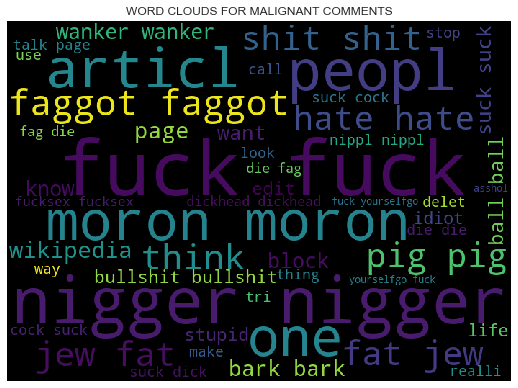

In [35]:
malignant = cmt['comment'][cmt['malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR MALIGNANT COMMENTS')
plt.show()

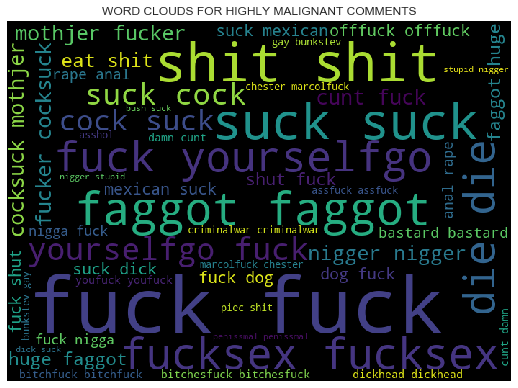

In [36]:
highly_malignant = cmt['comment'][cmt['highly_malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(highly_malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR HIGHLY MALIGNANT COMMENTS')
plt.show()

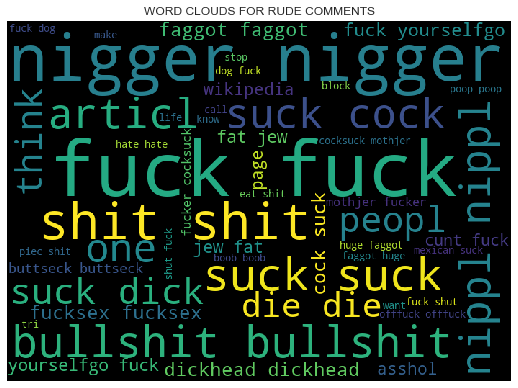

In [37]:
rude = cmt['comment'][cmt['rude']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(rude))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR RUDE COMMENTS')
plt.show()

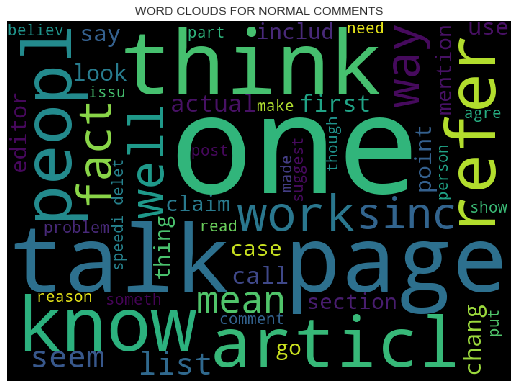

In [38]:
normal = cmt['comment'][cmt['normal']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(normal))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR NORMAL COMMENTS')
plt.show()

# MODELLING 

In [39]:
cmt.sample(4)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
91015,"Please stop making test edits to Wikipedia, as...",0,0,0,0,0,0,1,243,pleas stop make test edit wikipedia babylonian...,131
130506,"If it really bothers you pin a needed on it, ...",0,0,0,0,0,0,1,363,realli bother pin need differ thing chang ever...,155
104537,editing under signature of 151.201.48.208 on A...,0,0,0,0,0,0,1,115,edit signatur afd page edit signatur draktu af...,52
71030,""" Hi, Uac1530, Welcome to Wikipedia! \nI hope...",0,0,0,0,0,0,1,1906,uac welcom wikipedia hope place sure want stay...,970


In [40]:
X=cmt.comment
y=cmt.iloc[:,1:-3]

In [41]:
X.head(4)

0    explan edit made usernam hardcor metallica fan...
1         match background colour seemingli stuck talk
2    man realli tri edit war guy constantli remov r...
3    make real suggest improv wonder section statis...
Name: comment, dtype: object

In [42]:
y.head(4)

,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1


In [43]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=8000,ngram_range=(1,3))

In [44]:
x=tfidf.fit_transform(X).toarray()

In [45]:
#CHECKING THE SELECTED FEATURE NAMES
tfidf.get_feature_names()[1:9]

['abc', 'abid', 'abil', 'abort', 'abraham', 'abroad', 'absenc', 'absent']

In [46]:
x_train,x_test,y_train,y_test=tts(x,y,test_size=0.30,random_state=95)

In [47]:
print('shape of x_train:',x_train.shape,'\nshape of x_test:',x_test.shape)

print('shape of y_train:',y_train.shape,'\nshape of y_test:',y_test.shape)

shape of x_train: (111699, 8000) 
shape of x_test: (47872, 8000)
shape of y_train: (111699, 7) 
shape of y_test: (47872, 7)


In [48]:
labels=['malignant','highly_malignant','rude','threat','abuse','loathe','normal']

### LOGISTIC REGRESSION

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9561330213903744

F1 score: 0.7252028264852132

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43299
           1       0.90      0.61      0.73      4573

    accuracy                           0.96     47872
   macro avg       0.93      0.80      0.85     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.9028999674160965

RECALL:
 0.6059479553903345

MEAN SQUARED ERROR:
 0.04386697860962567

ROOT MEAN SQ. ERROR:
 0.20944445232477674

LOG_LOSS: 1.5151167427587455

AUC_ROC Score:
 0.7995327896769682

TPR: [0.         0.00688238 1.        ] 
FPR: [0.         0.60594796 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



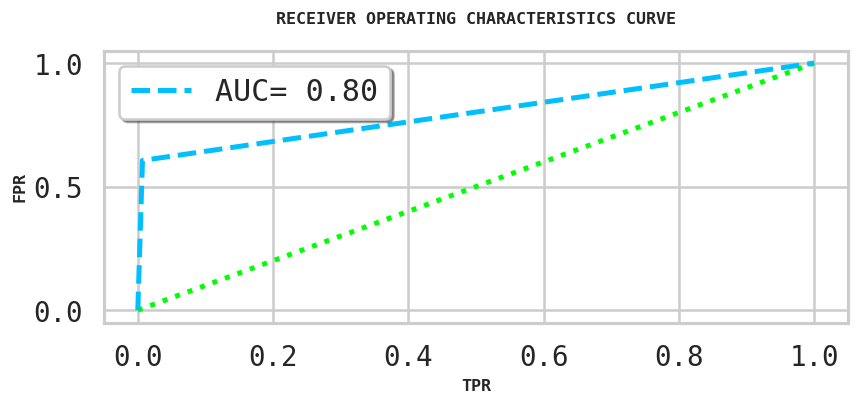





	____________________________________________CONFUSION MATRIX___________________________________________



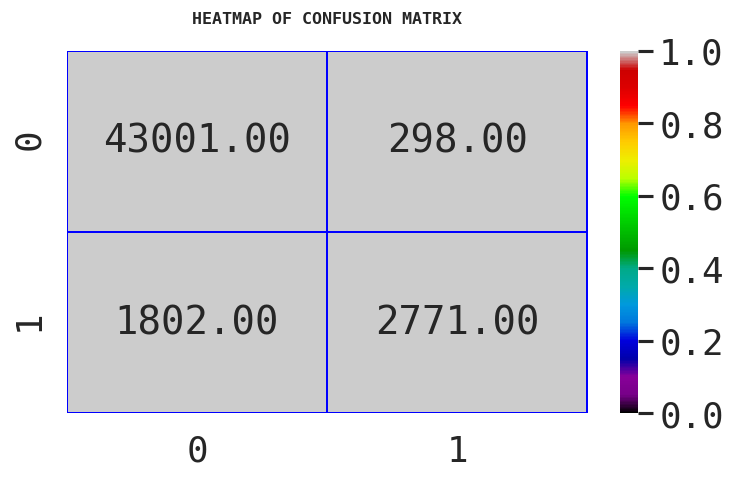



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9904537098930482

F1 score: 0.2958397534668721

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47425
           1       0.48      0.21      0.30       447

    accuracy                           0.99     47872
   macro avg       0.73      0.61      0.65     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.4752475247524752

RECALL:
 0.21476510067114093

MEAN SQUARED ERROR:
 0.009546290106951872

ROOT MEAN SQ. ERROR:
 0.09770511812055636

LOG_LOSS: 0.3297189499039486

AUC_ROC Score:
 0.6062649963028872

TPR: [0.         0.00223511 1.        ] 
FPR: [0.        0.2147651 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



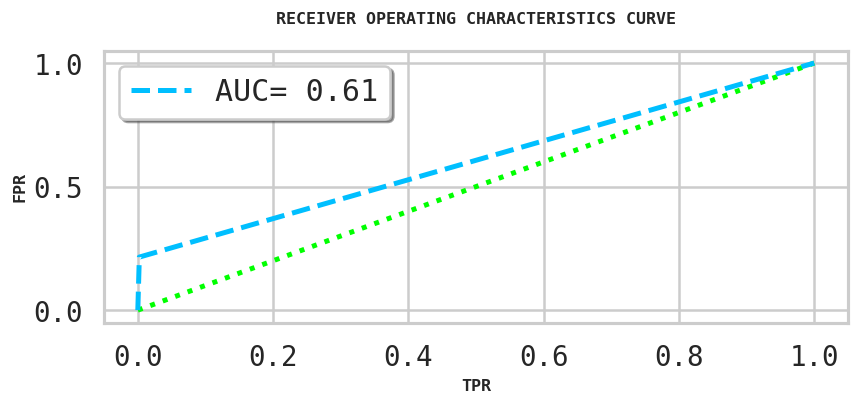





	____________________________________________CONFUSION MATRIX___________________________________________



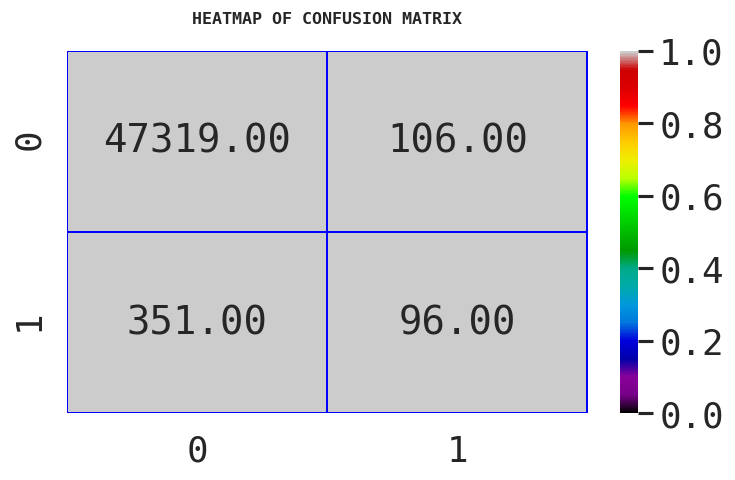



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9775860628342246

F1 score: 0.7487707796768907

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     45359
           1       0.91      0.64      0.75      2513

    accuracy                           0.98     47872
   macro avg       0.94      0.82      0.87     47872
weighted avg       0.98      0.98      0.98     47872


PRECISION:
 0.909556313993174

RECALL:
 0.6362912853163549

MEAN SQUARED ERROR:
 0.022413937165775402

ROOT MEAN SQ. ERROR:
 0.14971284903365978

LOG_LOSS: 0.774152619646779

AUC_ROC Score:
 0.8163929585161108

TPR: [0.         0.00350537 1.        ] 
FPR: [0.         0.63629129 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



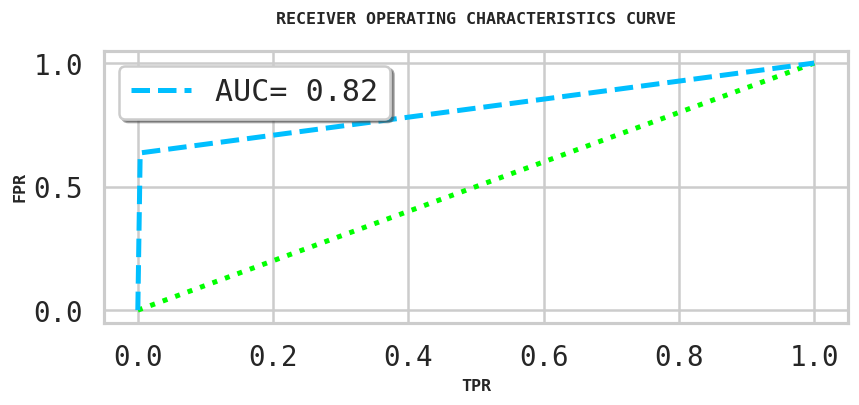





	____________________________________________CONFUSION MATRIX___________________________________________



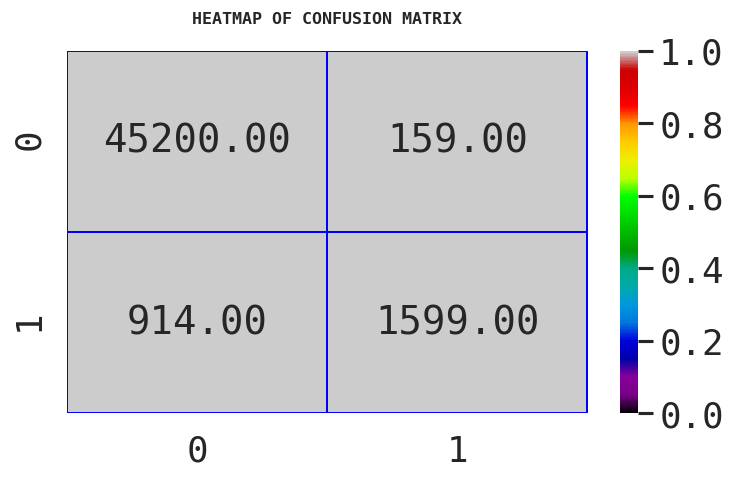



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9972635360962567

F1 score: 0.14379084967320263

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.61      0.08      0.14       135

    accuracy                           1.00     47872
   macro avg       0.80      0.54      0.57     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.6111111111111112

RECALL:
 0.08148148148148149

MEAN SQUARED ERROR:
 0.0027364639037433156

ROOT MEAN SQ. ERROR:
 0.052311221585270934

LOG_LOSS: 0.09451423180388031

AUC_ROC Score:
 0.5406674223503936

TPR: [0.00000000e+00 1.46636781e-04 1.00000000e+00] 
FPR: [0.         0.08148148 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



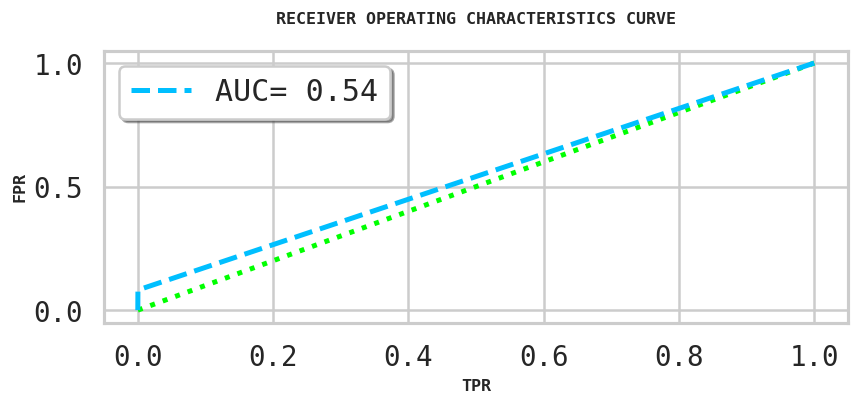





	____________________________________________CONFUSION MATRIX___________________________________________



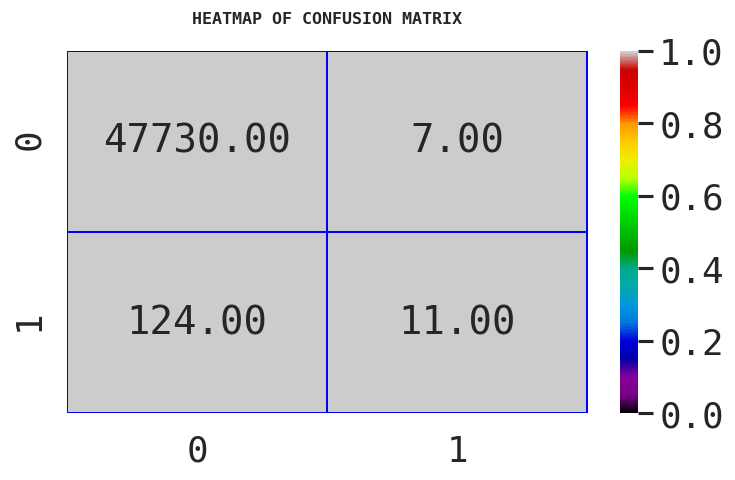



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9702540106951871

F1 score: 0.6250658241179569

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     45531
           1       0.81      0.51      0.63      2341

    accuracy                           0.97     47872
   macro avg       0.89      0.75      0.80     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.814687714481812

RECALL:
 0.5070482699700982

MEAN SQUARED ERROR:
 0.029745989304812835

ROOT MEAN SQ. ERROR:
 0.17247025629021612

LOG_LOSS: 1.0273945830059117

AUC_ROC Score:
 0.7505591221366601

TPR: [0.         0.00593003 1.        ] 
FPR: [0.         0.50704827 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



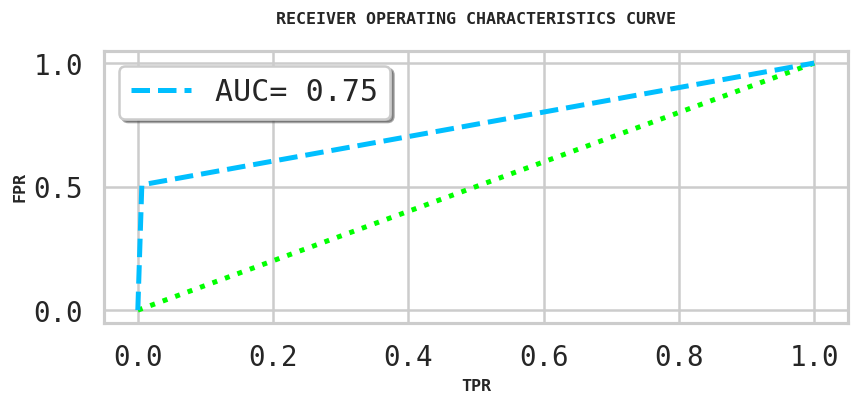





	____________________________________________CONFUSION MATRIX___________________________________________



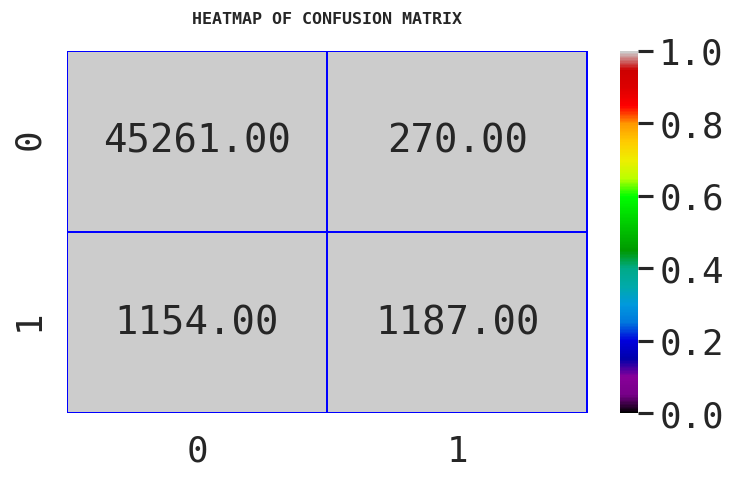



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9918114973262032

F1 score: 0.2547528517110266

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.66      0.16      0.25       424

    accuracy                           0.99     47872
   macro avg       0.82      0.58      0.63     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.6568627450980392

RECALL:
 0.1580188679245283

MEAN SQUARED ERROR:
 0.008188502673796791

ROOT MEAN SQ. ERROR:
 0.09049034574912836

LOG_LOSS: 0.2828214474581194

AUC_ROC Score:
 0.5786406091435151

TPR: [0.00000000e+00 7.37649637e-04 1.00000000e+00] 
FPR: [0.         0.15801887 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



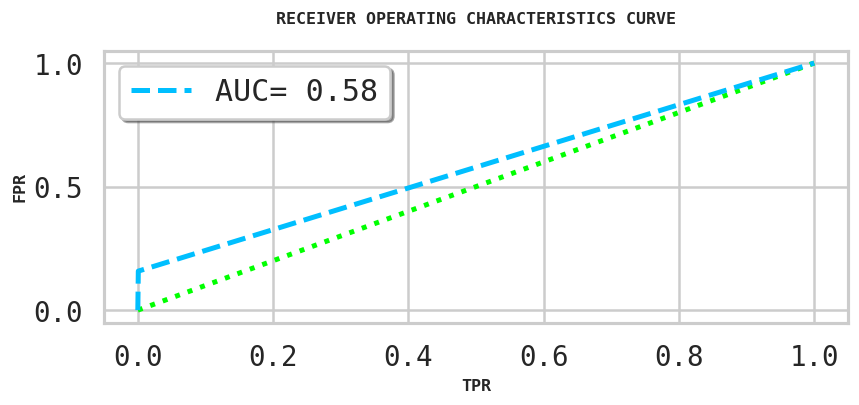





	____________________________________________CONFUSION MATRIX___________________________________________



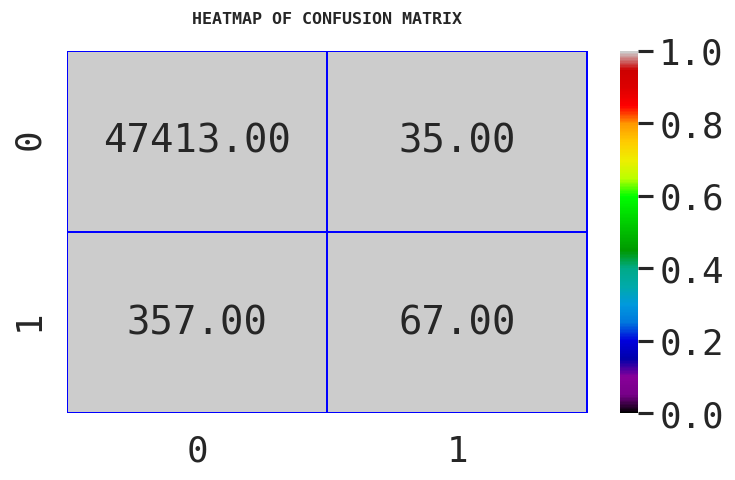



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9558614639037433

F1 score: 0.9758886289724426

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      4844
           1       0.96      0.99      0.98     43028

    accuracy                           0.96     47872
   macro avg       0.94      0.81      0.86     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.9586163606608828

RECALL:
 0.9937947383099377

MEAN SQUARED ERROR:
 0.04413853609625668

ROOT MEAN SQ. ERROR:
 0.21009173257474145

LOG_LOSS: 1.5245218620342256

AUC_ROC Score:
 0.8063523650261497

TPR: [0.         0.38109001 1.        ] 
FPR: [0.         0.99379474 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



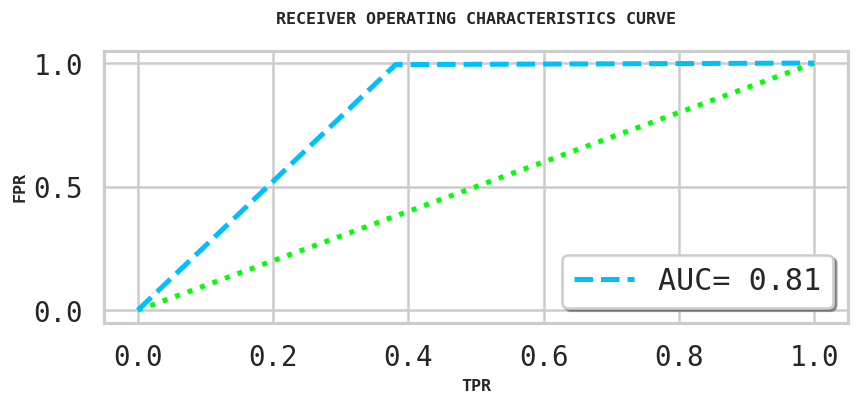





	____________________________________________CONFUSION MATRIX___________________________________________



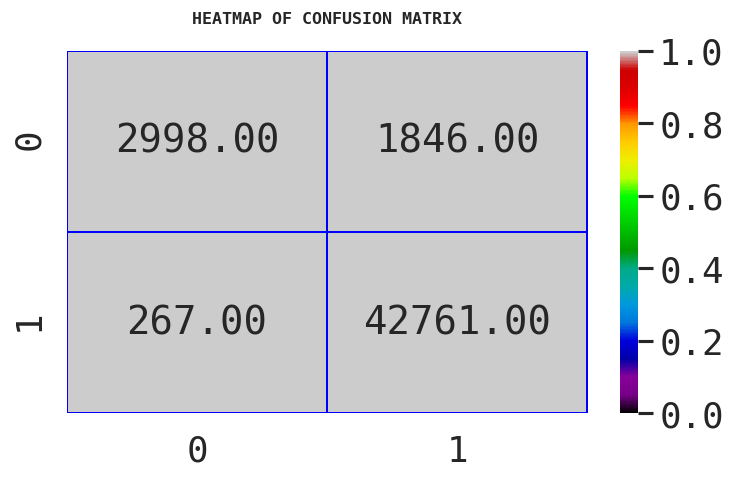

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.725203,0.956133,0.902900,0.605948,0.209444,0.043867,0.799533,1.515117
1,highly_malignant,0.295840,0.990454,0.475248,0.214765,0.097705,0.009546,0.606265,0.329719
2,rude,0.748771,0.977586,0.909556,0.636291,0.149713,0.022414,0.816393,0.774153
3,threat,0.143791,0.997264,0.611111,0.081481,0.052311,0.002736,0.540667,0.094514
4,abuse,0.625066,0.970254,0.814688,0.507048,0.172470,0.029746,0.750559,1.027395
5,loathe,0.254753,0.991811,0.656863,0.158019,0.090490,0.008189,0.578641,0.282821
6,normal,0.975889,0.955861,0.958616,0.993795,0.210092,0.044139,0.806352,1.524522


In [49]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    LogReg_pipeline.fit(x_train, y_train[category])
    pred = LogReg_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})                                

### PASSIVE AGGRESSIVE CLASSIFIER

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9543992312834224

F1 score: 0.7227936507936508

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43299
           1       0.86      0.62      0.72      4573

    accuracy                           0.95     47872
   macro avg       0.91      0.81      0.85     47872
weighted avg       0.95      0.95      0.95     47872


PRECISION:
 0.8619018776499091

RECALL:
 0.62234856767986

MEAN SQUARED ERROR:
 0.04560076871657754

ROOT MEAN SQ. ERROR:
 0.21354336495563972

LOG_LOSS: 1.5750023706241276

AUC_ROC Score:
 0.8059085733154376

TPR: [0.         0.01053142 1.        ] 
FPR: [0.         0.62234857 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



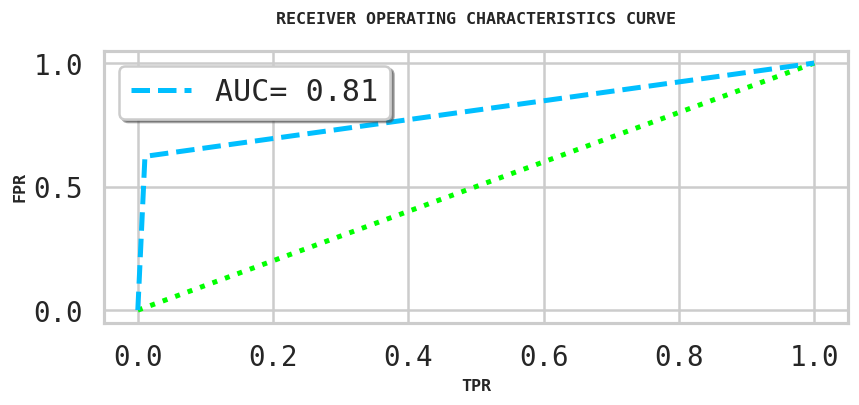





	____________________________________________CONFUSION MATRIX___________________________________________



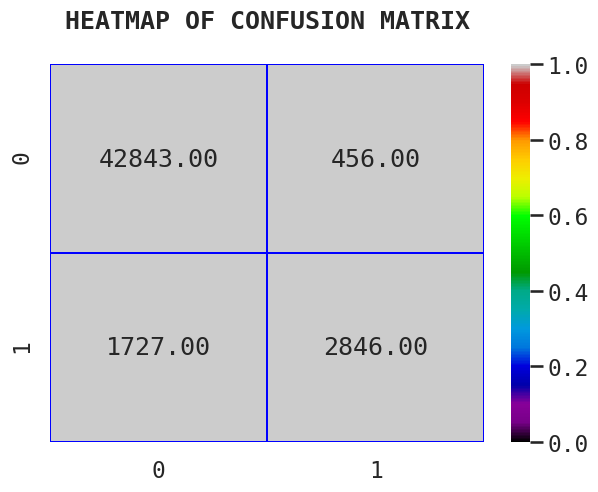



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9877172459893048

F1 score: 0.3538461538461538

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47425
           1       0.35      0.36      0.35       447

    accuracy                           0.99     47872
   macro avg       0.67      0.68      0.67     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.34773218142548595

RECALL:
 0.36017897091722595

MEAN SQUARED ERROR:
 0.012282754010695188

ROOT MEAN SQ. ERROR:
 0.11082758686669664

LOG_LOSS: 0.4242363385409309

AUC_ROC Score:
 0.6769055107617232

TPR: [0.         0.00636795 1.        ] 
FPR: [0.         0.36017897 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



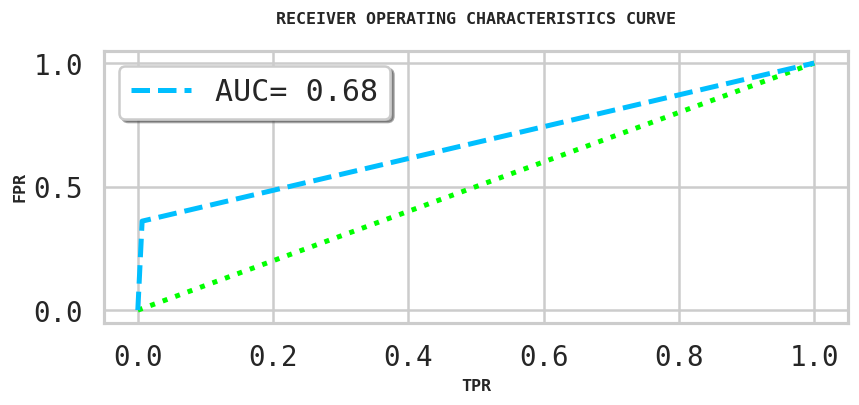





	____________________________________________CONFUSION MATRIX___________________________________________



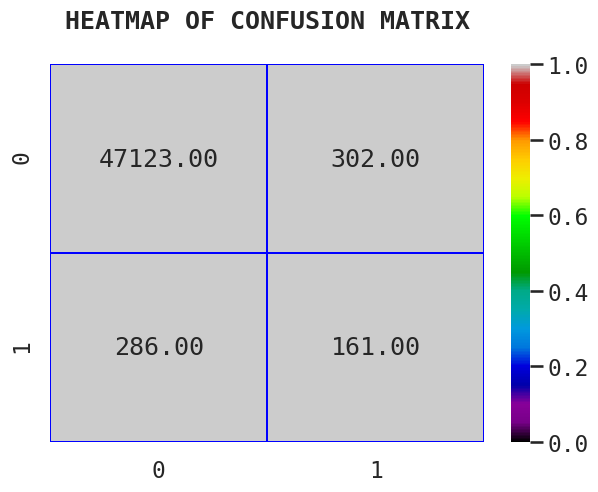



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9770011697860963

F1 score: 0.7535258562793822

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     45359
           1       0.86      0.67      0.75      2513

    accuracy                           0.98     47872
   macro avg       0.92      0.83      0.87     47872
weighted avg       0.98      0.98      0.98     47872


PRECISION:
 0.861310133060389

RECALL:
 0.6697174691603661

MEAN SQUARED ERROR:
 0.022998830213903743

ROOT MEAN SQ. ERROR:
 0.15165365216144233

LOG_LOSS: 0.7943559805669343

AUC_ROC Score:
 0.8318714553191764

TPR: [0.         0.00597456 1.        ] 
FPR: [0.         0.66971747 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



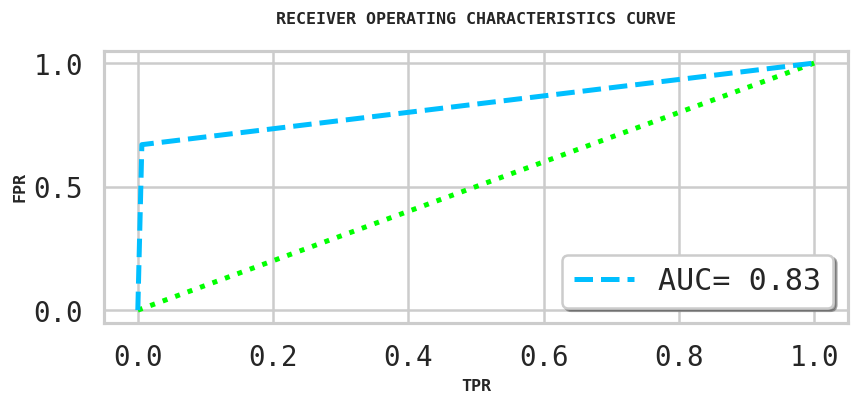





	____________________________________________CONFUSION MATRIX___________________________________________



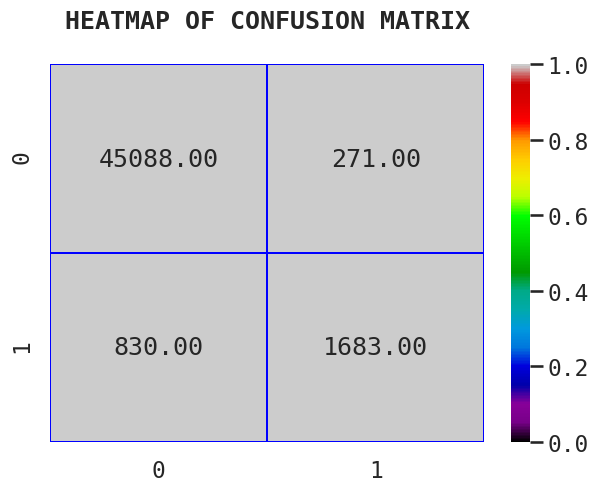



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9950701871657754

F1 score: 0.3179190751445087

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.26      0.41      0.32       135

    accuracy                           1.00     47872
   macro avg       0.63      0.70      0.66     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.26066350710900477

RECALL:
 0.4074074074074074

MEAN SQUARED ERROR:
 0.004929812834224599

ROOT MEAN SQ. ERROR:
 0.07021262588897098

LOG_LOSS: 0.1702723087900668

AUC_ROC Score:
 0.7020697510045396

TPR: [0.         0.00326791 1.        ] 
FPR: [0.         0.40740741 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



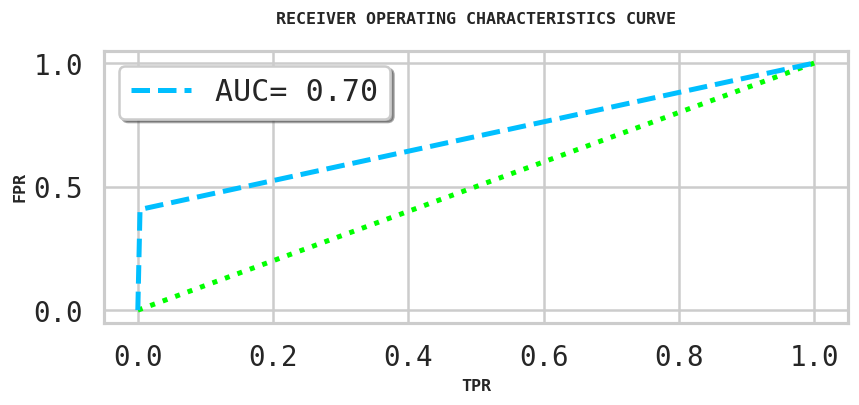





	____________________________________________CONFUSION MATRIX___________________________________________



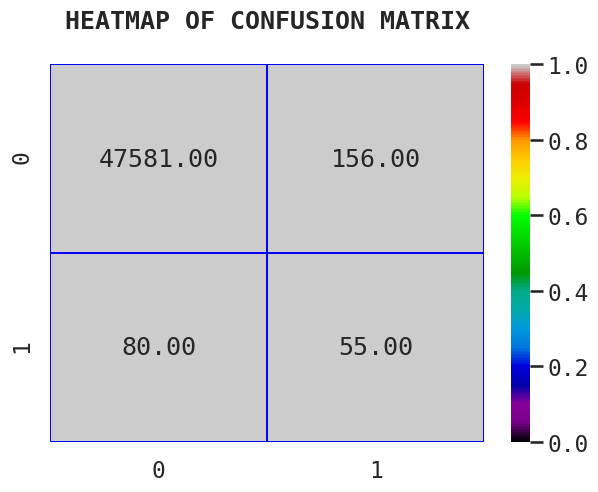



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9654913101604278

F1 score: 0.6319073083778967

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     45531
           1       0.66      0.61      0.63      2341

    accuracy                           0.97     47872
   macro avg       0.82      0.79      0.81     47872
weighted avg       0.96      0.97      0.96     47872


PRECISION:
 0.6604564508616675

RECALL:
 0.6057240495514737

MEAN SQUARED ERROR:
 0.03450868983957219

ROOT MEAN SQ. ERROR:
 0.1857651469990326

LOG_LOSS: 1.1919000984065655

AUC_ROC Score:
 0.7948564900850865

TPR: [0.         0.01601107 1.        ] 
FPR: [0.         0.60572405 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



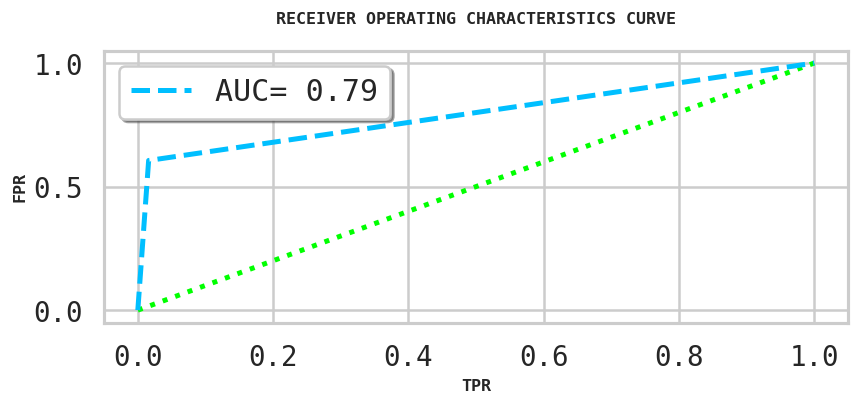





	____________________________________________CONFUSION MATRIX___________________________________________



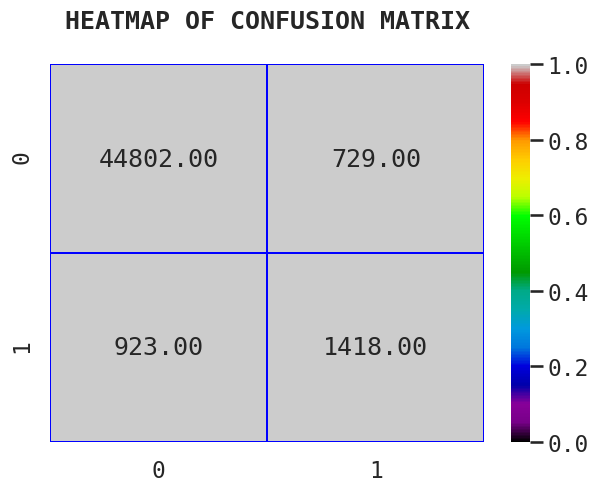



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9921666109625669

F1 score: 0.3267504488330341

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.68      0.21      0.33       424

    accuracy                           0.99     47872
   macro avg       0.84      0.61      0.66     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.6842105263157895

RECALL:
 0.21462264150943397

MEAN SQUARED ERROR:
 0.007833389037433155

ROOT MEAN SQ. ERROR:
 0.08850643500578449

LOG_LOSS: 0.27055637389671666

AUC_ROC Score:
 0.6068687309722183

TPR: [0.00000000e+00 8.85179565e-04 1.00000000e+00] 
FPR: [0.         0.21462264 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



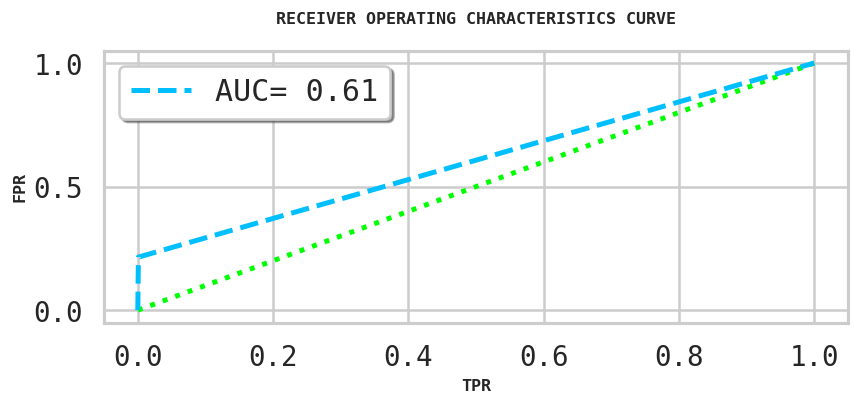





	____________________________________________CONFUSION MATRIX___________________________________________



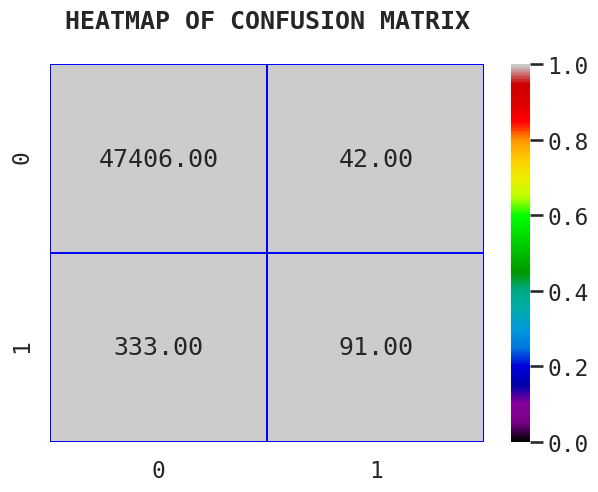



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9497409759358288

F1 score: 0.9721630877452796

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74      4844
           1       0.97      0.98      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.87      0.84      0.86     47872
weighted avg       0.95      0.95      0.95     47872


PRECISION:
 0.967952262464289

RECALL:
 0.9764107093055685

MEAN SQUARED ERROR:
 0.050259024064171126

ROOT MEAN SQ. ERROR:
 0.2241852449742648

LOG_LOSS: 1.7359084276023675

AUC_ROC Score:
 0.8446256684430402

TPR: [0.         0.28715937 1.        ] 
FPR: [0.         0.97641071 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



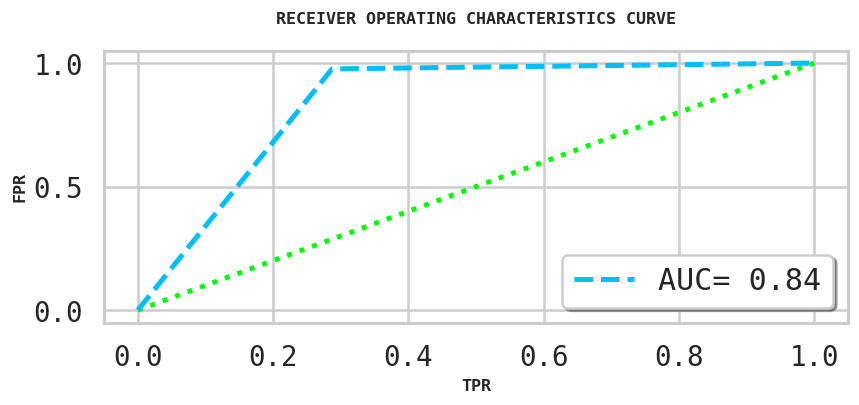





	____________________________________________CONFUSION MATRIX___________________________________________



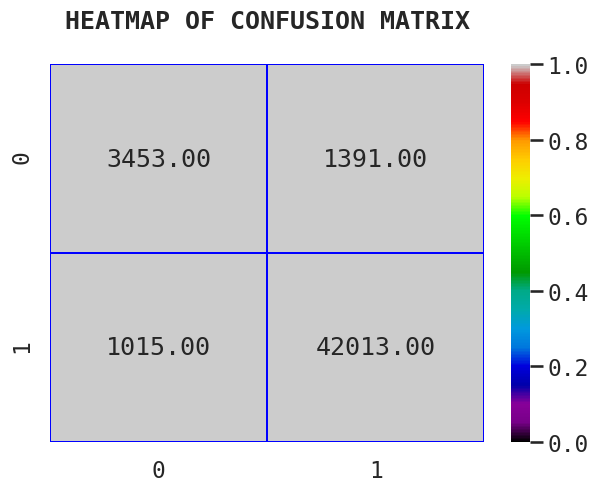

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.722794,0.954399,0.861902,0.622349,0.213543,0.045601,0.805909,1.575002
1,highly_malignant,0.353846,0.987717,0.347732,0.360179,0.110828,0.012283,0.676906,0.424236
2,rude,0.753526,0.977001,0.861310,0.669717,0.151654,0.022999,0.831871,0.794356
3,threat,0.317919,0.995070,0.260664,0.407407,0.070213,0.004930,0.702070,0.170272
4,abuse,0.631907,0.965491,0.660456,0.605724,0.185765,0.034509,0.794856,1.191900
5,loathe,0.326750,0.992167,0.684211,0.214623,0.088506,0.007833,0.606869,0.270556
6,normal,0.972163,0.949741,0.967952,0.976411,0.224185,0.050259,0.844626,1.735908


In [50]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    pac_pipeline.fit(x_train, y_train[category])
    pred = pac_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### MULTINOMIAL NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9480280748663101

F1 score: 0.6463899943149517

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     43299
           1       0.92      0.50      0.65      4573

    accuracy                           0.95     47872
   macro avg       0.94      0.75      0.81     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9232643118148599

RECALL:
 0.4972665646184124

MEAN SQUARED ERROR:
 0.05197192513368984

ROOT MEAN SQ. ERROR:
 0.2279735184921482

LOG_LOSS: 1.7950498578386553

AUC_ROC Score:
 0.7464507838681337

TPR: [0.       0.004365 1.      ] 
FPR: [0.         0.49726656 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



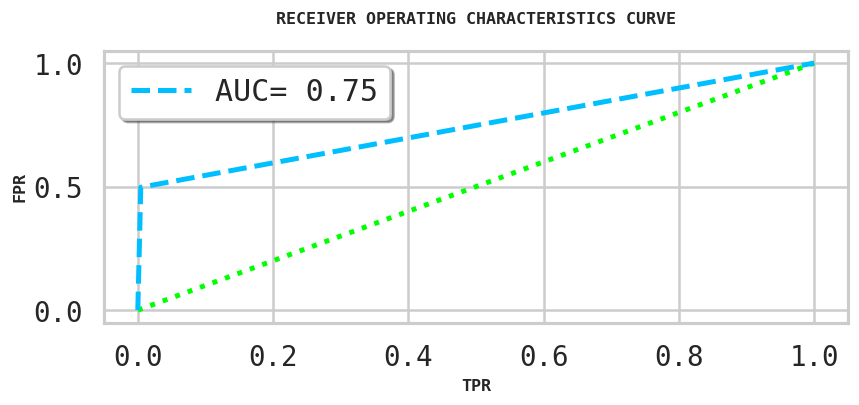





	____________________________________________CONFUSION MATRIX___________________________________________



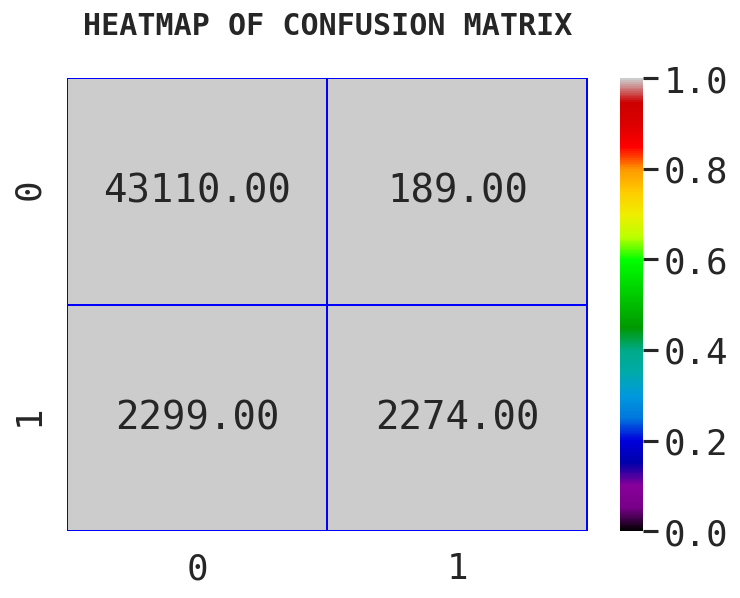



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9891377005347594

F1 score: 0.23529411764705885

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47425
           1       0.34      0.18      0.24       447

    accuracy                           0.99     47872
   macro avg       0.67      0.59      0.61     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.34334763948497854

RECALL:
 0.1789709172259508

MEAN SQUARED ERROR:
 0.010862299465240642

ROOT MEAN SQ. ERROR:
 0.10422235588030354

LOG_LOSS: 0.37517308789606496

AUC_ROC Score:
 0.5878723853393855

TPR: [0.         0.00322615 1.        ] 
FPR: [0.         0.17897092 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



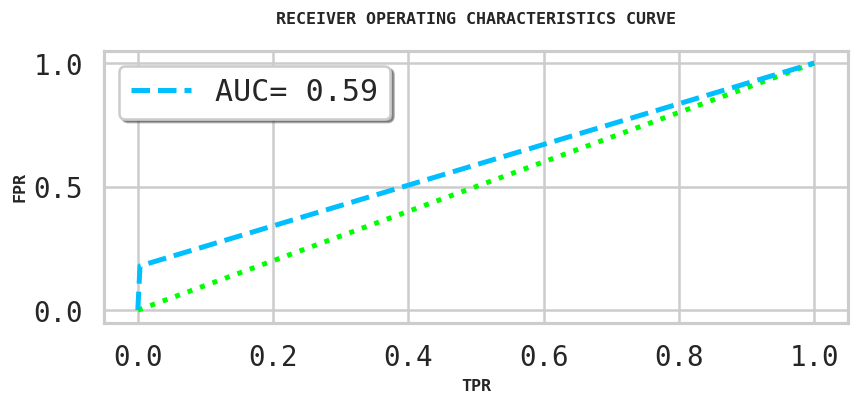





	____________________________________________CONFUSION MATRIX___________________________________________



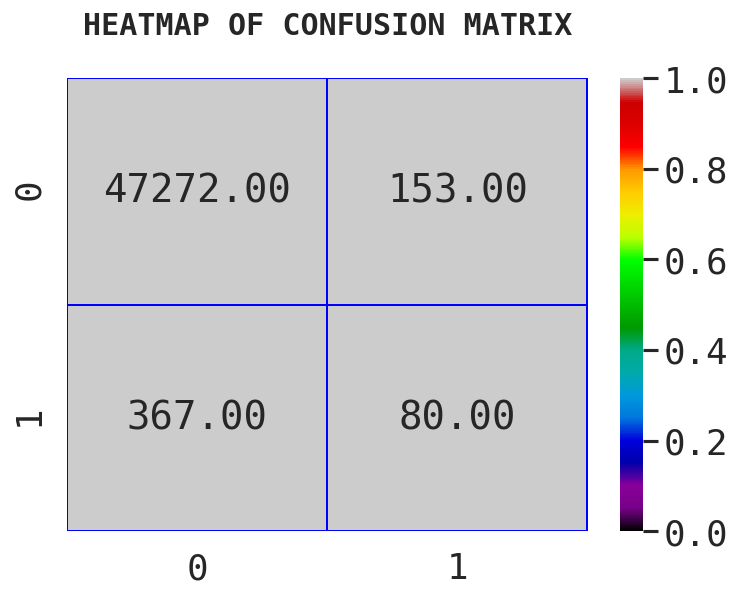



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9712775735294118

F1 score: 0.6539139189529323

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     45359
           1       0.89      0.52      0.65      2513

    accuracy                           0.97     47872
   macro avg       0.93      0.76      0.82     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.8897260273972603

RECALL:
 0.5169120573020295

MEAN SQUARED ERROR:
 0.028722426470588234

ROOT MEAN SQ. ERROR:
 0.16947692017082513

LOG_LOSS: 0.9920401545410363

AUC_ROC Score:
 0.7566812981675384

TPR: [0.         0.00354946 1.        ] 
FPR: [0.         0.51691206 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



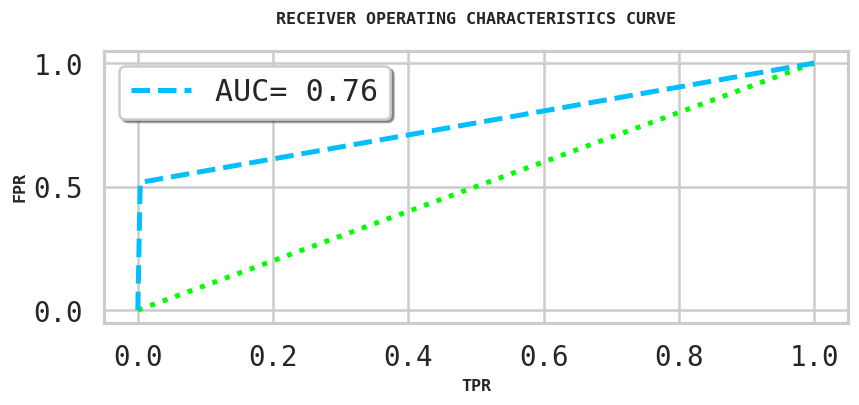





	____________________________________________CONFUSION MATRIX___________________________________________



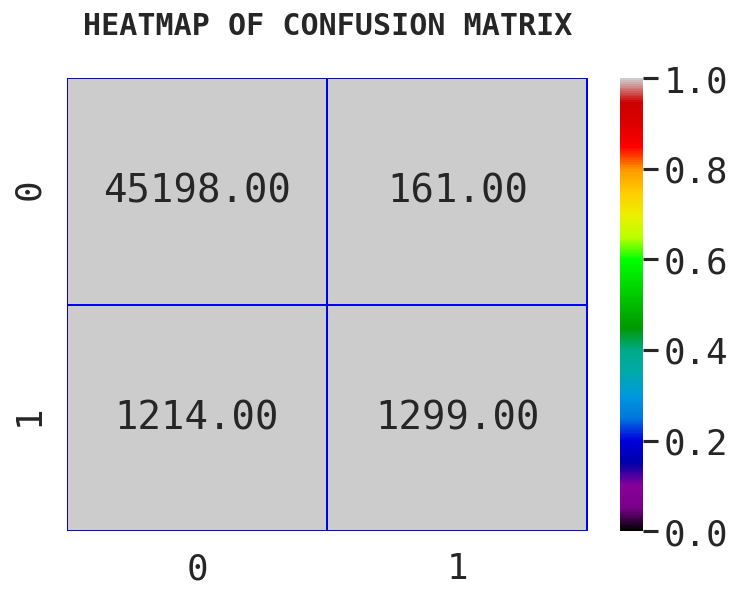



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9949448529411765

F1 score: 0.0

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.00      0.00      0.00       135

    accuracy                           0.99     47872
   macro avg       0.50      0.50      0.50     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.00505514705882353

ROOT MEAN SQ. ERROR:
 0.07109955737431513

LOG_LOSS: 0.1746003811099069

AUC_ROC Score:
 0.4988792760332656

TPR: [0.         0.00224145 1.        ] 
FPR: [0. 0. 1.]




	____________________________________________ROC_AUC CURVE_______________________________________________



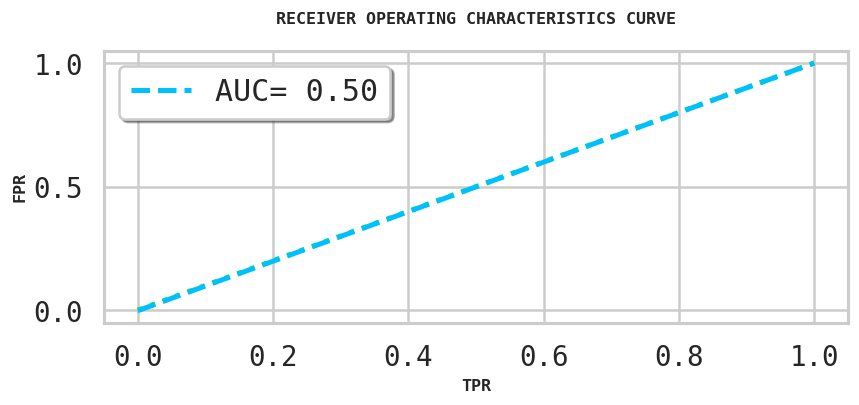





	____________________________________________CONFUSION MATRIX___________________________________________



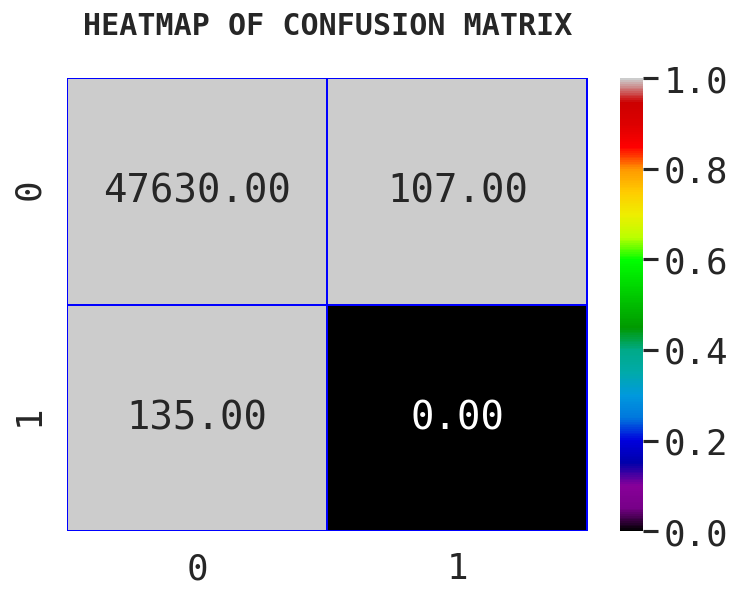



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9665775401069518

F1 score: 0.5510662177328844

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     45531
           1       0.80      0.42      0.55      2341

    accuracy                           0.97     47872
   macro avg       0.89      0.71      0.77     47872
weighted avg       0.96      0.97      0.96     47872


PRECISION:
 0.802943581357318

RECALL:
 0.4194788551900897

MEAN SQUARED ERROR:
 0.03342245989304813

ROOT MEAN SQ. ERROR:
 0.18281810603178267

LOG_LOSS: 1.1543748941936374

AUC_ROC Score:
 0.7070928790896309

TPR: [0.        0.0052931 1.       ] 
FPR: [0.         0.41947886 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



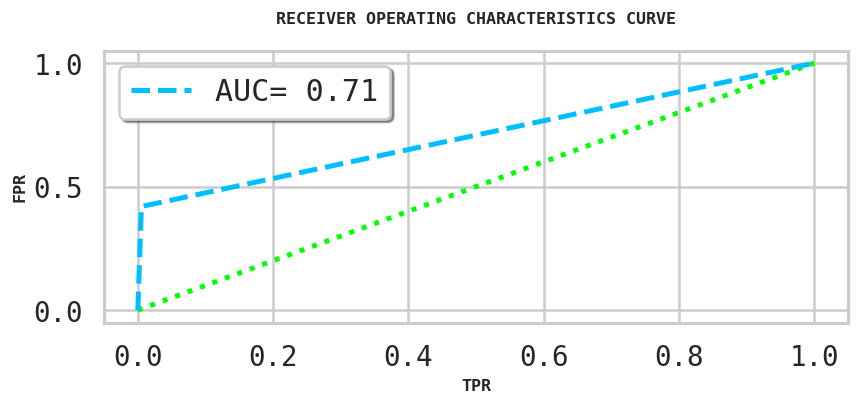





	____________________________________________CONFUSION MATRIX___________________________________________



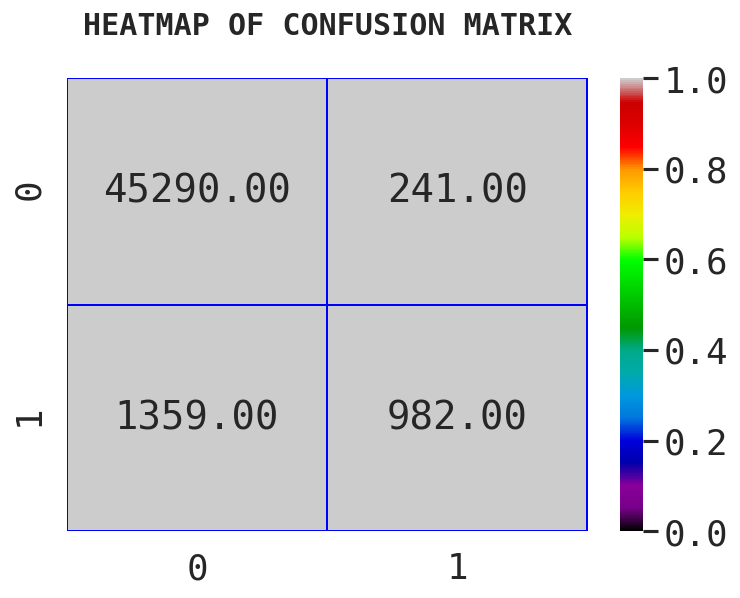



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9892630347593583

F1 score: 0.11379310344827585

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47448
           1       0.21      0.08      0.11       424

    accuracy                           0.99     47872
   macro avg       0.60      0.54      0.55     47872
weighted avg       0.98      0.99      0.99     47872


PRECISION:
 0.21153846153846154

RECALL:
 0.07783018867924528

MEAN SQUARED ERROR:
 0.01073696524064171

ROOT MEAN SQ. ERROR:
 0.10361932850893076

LOG_LOSS: 0.3708436960533935

AUC_ROC Score:
 0.5376189385480192

TPR: [0.         0.00259231 1.        ] 
FPR: [0.         0.07783019 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



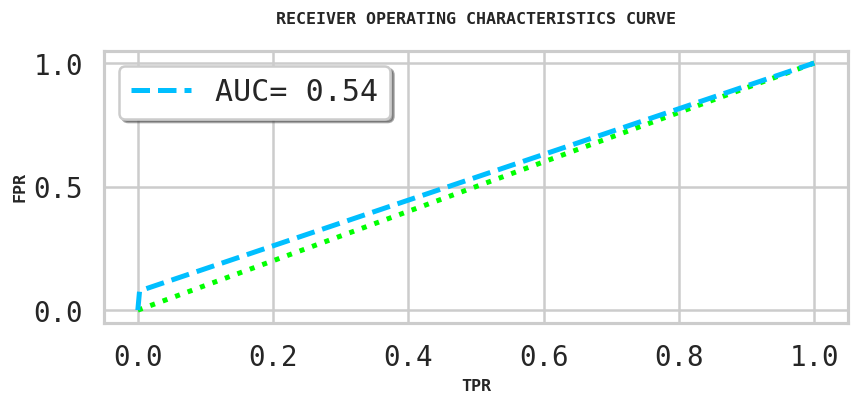





	____________________________________________CONFUSION MATRIX___________________________________________



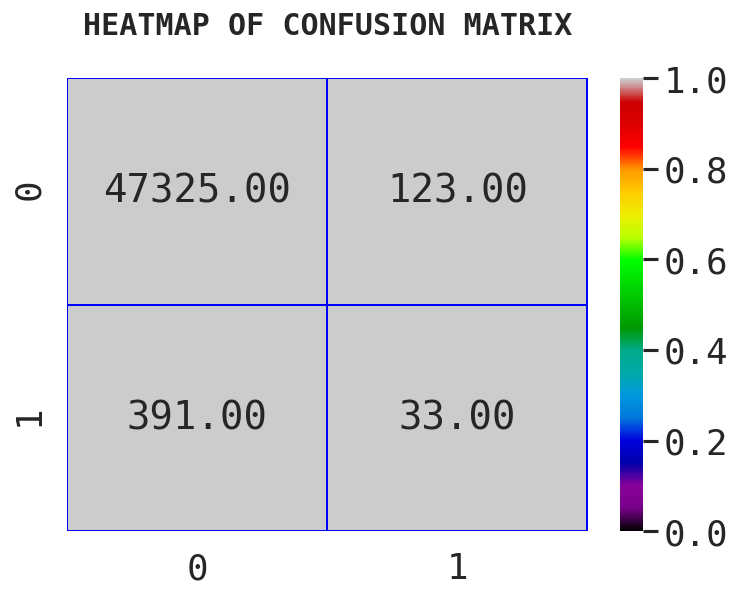



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9469836229946524

F1 score: 0.9712420966755049

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.94      0.51      0.66      4844
           1       0.95      1.00      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.94      0.75      0.82     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9476407376287976

RECALL:
 0.9960490843171889

MEAN SQUARED ERROR:
 0.053016377005347594

ROOT MEAN SQ. ERROR:
 0.23025285449989016

LOG_LOSS: 1.8311603429352865

AUC_ROC Score:
 0.7535984480215177

TPR: [0.         0.48885219 1.        ] 
FPR: [0.         0.99604908 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



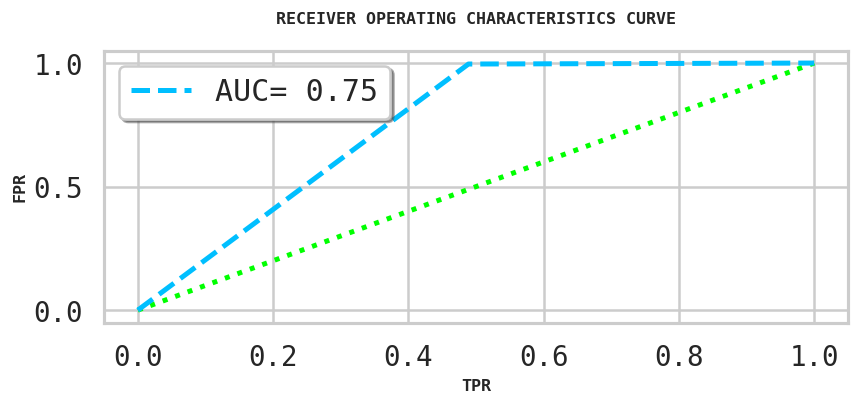





	____________________________________________CONFUSION MATRIX___________________________________________



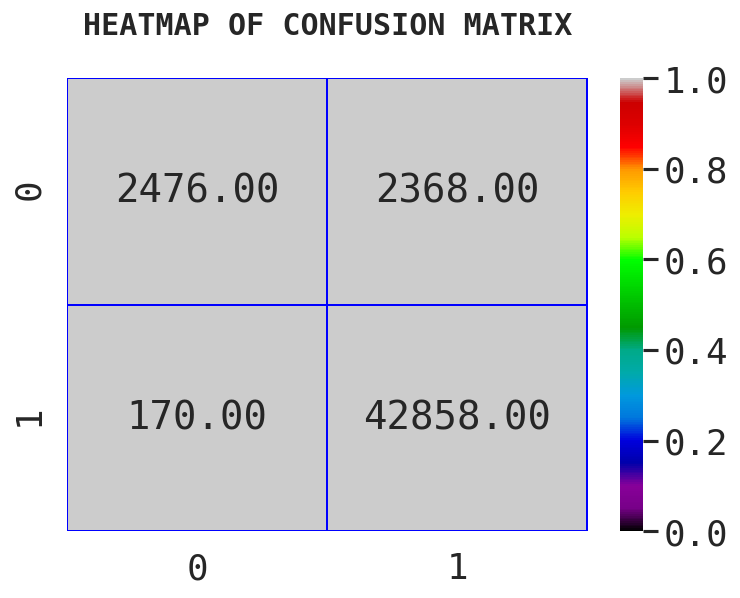

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.646390,0.948028,0.923264,0.497267,0.227974,0.051972,0.746451,1.795050
1,highly_malignant,0.235294,0.989138,0.343348,0.178971,0.104222,0.010862,0.587872,0.375173
2,rude,0.653914,0.971278,0.889726,0.516912,0.169477,0.028722,0.756681,0.992040
3,threat,0.000000,0.994945,0.000000,0.000000,0.071100,0.005055,0.498879,0.174600
4,abuse,0.551066,0.966578,0.802944,0.419479,0.182818,0.033422,0.707093,1.154375
5,loathe,0.113793,0.989263,0.211538,0.077830,0.103619,0.010737,0.537619,0.370844
6,normal,0.971242,0.946984,0.947641,0.996049,0.230253,0.053016,0.753598,1.831160


In [52]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(x_train, y_train[category])
    pred = MNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### COMPLEMENT NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8815591577540107

F1 score: 0.5854657113613102

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     43299
           1       0.44      0.88      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.71      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.4397583745194948

RECALL:
 0.8755740214301334

MEAN SQUARED ERROR:
 0.1184408422459893

ROOT MEAN SQ. ERROR:
 0.3441523532477866

LOG_LOSS: 4.090886967447255

AUC_ROC Score:
 0.8788826480277068

TPR: [0.         0.11780873 1.        ] 
FPR: [0.         0.87557402 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



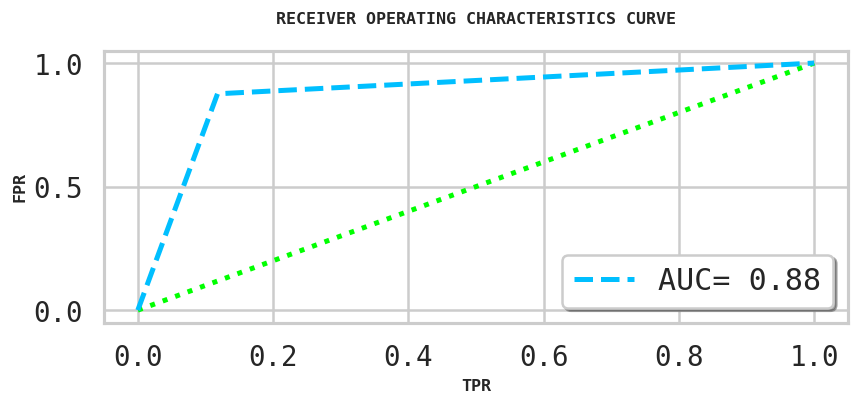





	____________________________________________CONFUSION MATRIX___________________________________________



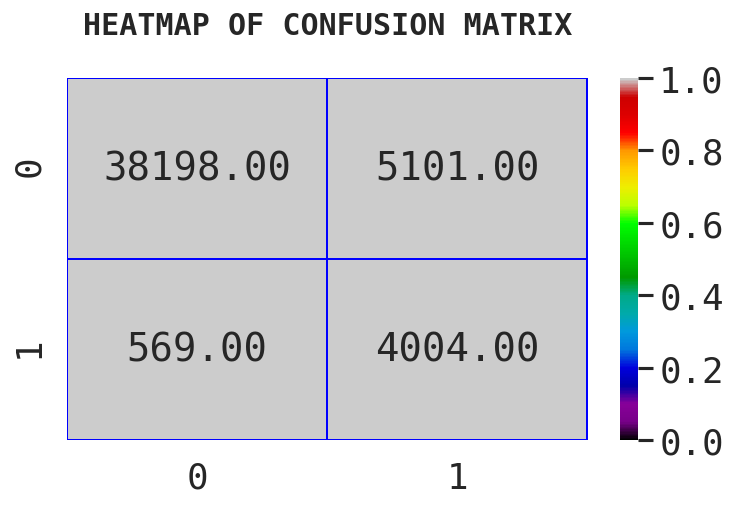



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9349097593582888

F1 score: 0.20061570035915857

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.11      0.87      0.20       447

    accuracy                           0.93     47872
   macro avg       0.56      0.91      0.58     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.11330049261083744

RECALL:
 0.8747203579418344

MEAN SQUARED ERROR:
 0.06509024064171123

ROOT MEAN SQ. ERROR:
 0.2551278907562073

LOG_LOSS: 2.2481883776461835

AUC_ROC Score:
 0.9050987134991195

TPR: [0.         0.06452293 1.        ] 
FPR: [0.         0.87472036 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



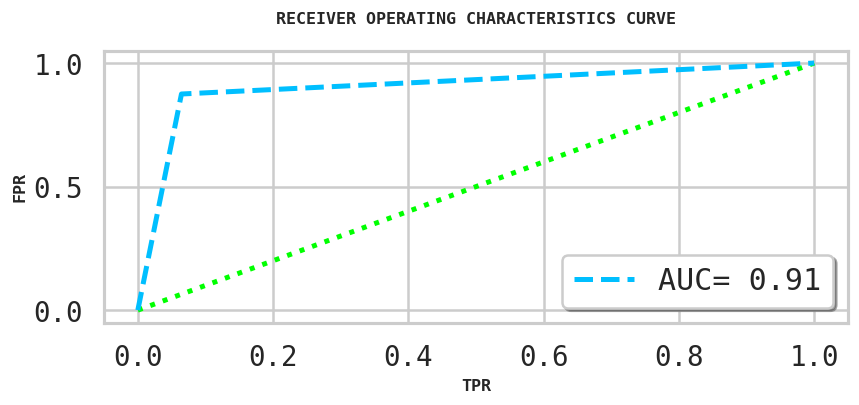





	____________________________________________CONFUSION MATRIX___________________________________________



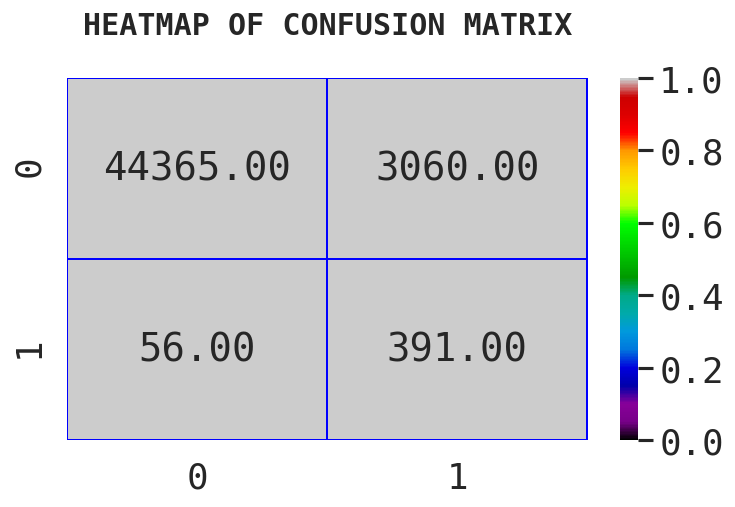



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9033673128342246

F1 score: 0.4898544331715924

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     45359
           1       0.34      0.88      0.49      2513

    accuracy                           0.90     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.33882532418001526

RECALL:
 0.8838042180660565

MEAN SQUARED ERROR:
 0.0966326871657754

ROOT MEAN SQ. ERROR:
 0.3108579855267923

LOG_LOSS: 3.3376471644827728

AUC_ROC Score:
 0.8941276871983316

TPR: [0.         0.09554884 1.        ] 
FPR: [0.         0.88380422 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



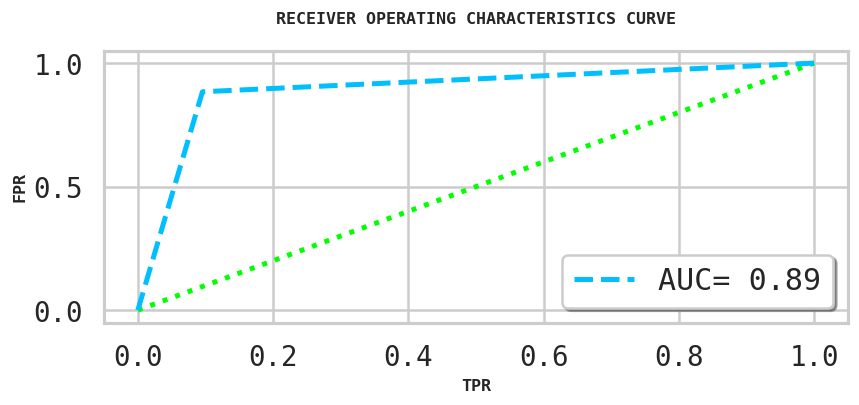





	____________________________________________CONFUSION MATRIX___________________________________________



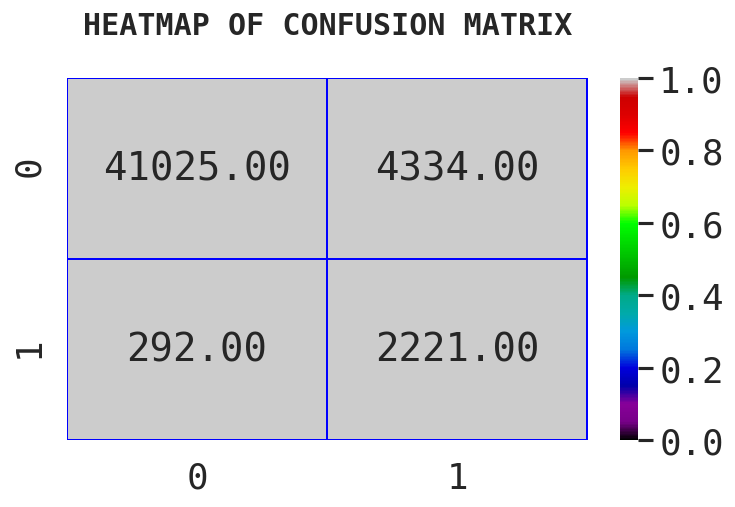



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9415315842245989

F1 score: 0.06168286959436809

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47737
           1       0.03      0.68      0.06       135

    accuracy                           0.94     47872
   macro avg       0.52      0.81      0.52     47872
weighted avg       1.00      0.94      0.97     47872


PRECISION:
 0.032303370786516857

RECALL:
 0.6814814814814815

MEAN SQUARED ERROR:
 0.05846841577540107

ROOT MEAN SQ. ERROR:
 0.24180243128513218

LOG_LOSS: 2.0194735716049603

AUC_ROC Score:
 0.8118742430555071

TPR: [0.       0.057733 1.      ] 
FPR: [0.         0.68148148 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



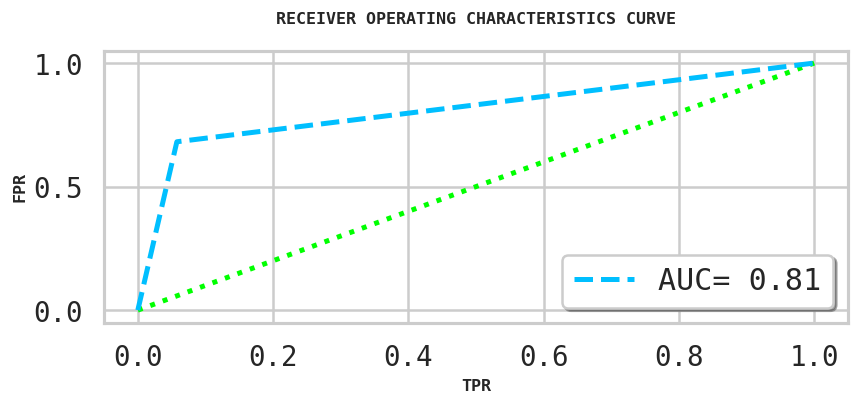





	____________________________________________CONFUSION MATRIX___________________________________________



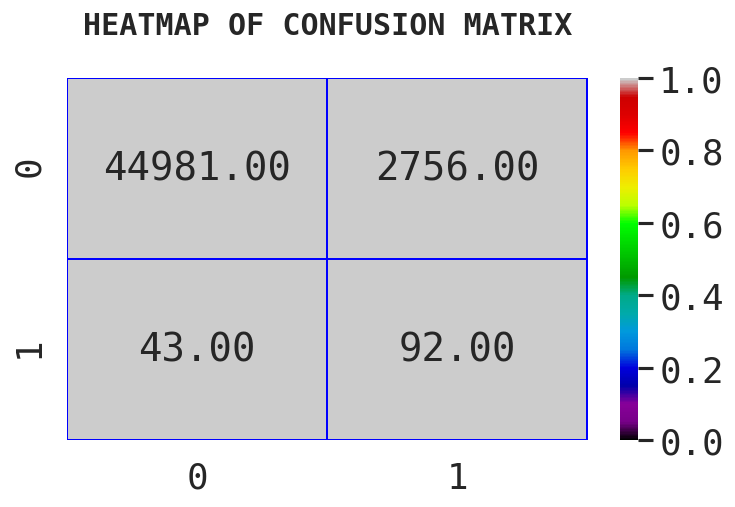



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9012366310160428

F1 score: 0.4674476233385898

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     45531
           1       0.32      0.89      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.3174238947529448

RECALL:
 0.8863733447244767

MEAN SQUARED ERROR:
 0.09876336898395723

ROOT MEAN SQ. ERROR:
 0.31426639811465246

LOG_LOSS: 3.4112404453307

AUC_ROC Score:
 0.894187089660343

TPR: [0.         0.09799917 1.        ] 
FPR: [0.         0.88637334 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



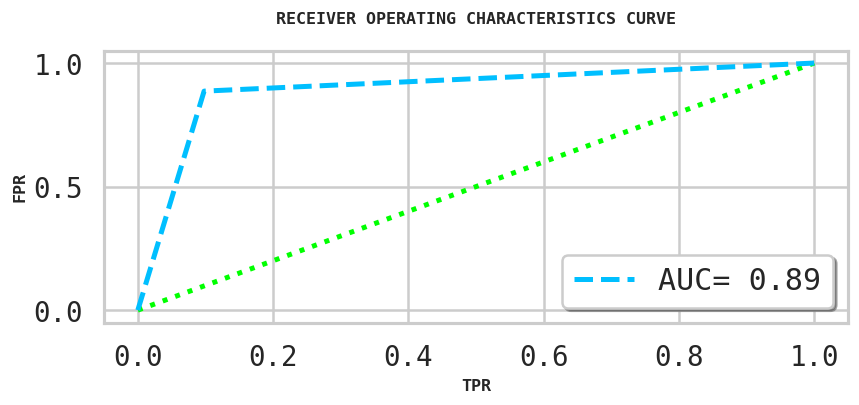





	____________________________________________CONFUSION MATRIX___________________________________________



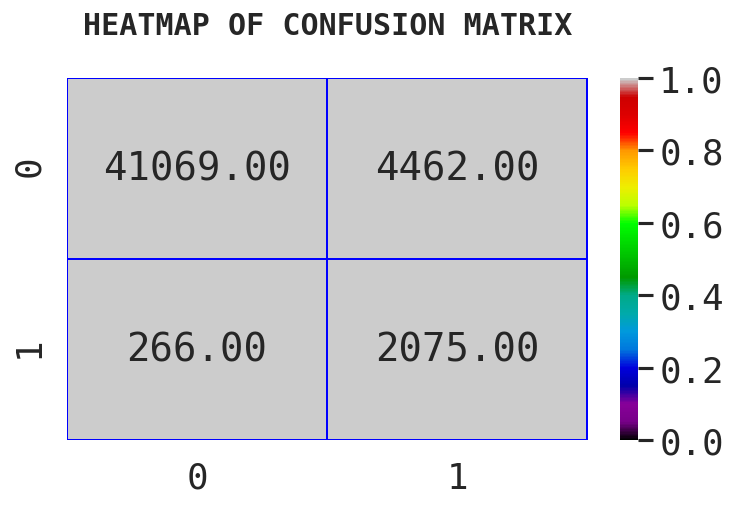



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9225643382352942

F1 score: 0.155773172398087

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     47448
           1       0.09      0.81      0.16       424

    accuracy                           0.92     47872
   macro avg       0.54      0.87      0.56     47872
weighted avg       0.99      0.92      0.95     47872


PRECISION:
 0.08621124275270986

RECALL:
 0.8066037735849056

MEAN SQUARED ERROR:
 0.07743566176470588

ROOT MEAN SQ. ERROR:
 0.2782726392671509

LOG_LOSS: 2.674593554407971

AUC_ROC Score:
 0.8651021734220262

TPR: [0.         0.07639943 1.        ] 
FPR: [0.         0.80660377 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



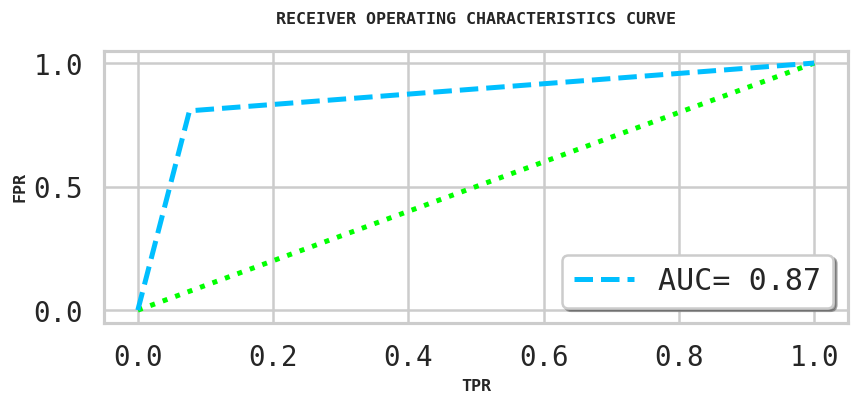





	____________________________________________CONFUSION MATRIX___________________________________________



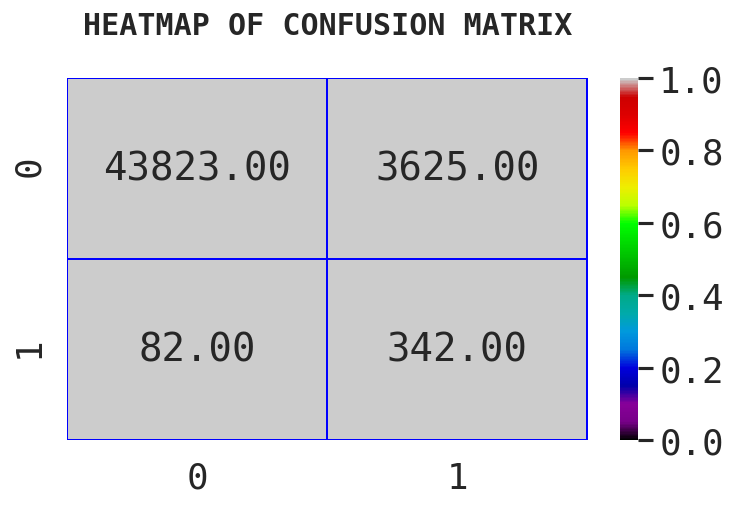



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8689839572192514

F1 score: 0.9224741044720773

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.43      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9852405344035486

RECALL:
 0.8672259923770568

MEAN SQUARED ERROR:
 0.13101604278074866

ROOT MEAN SQ. ERROR:
 0.3619613829965134

LOG_LOSS: 4.525143142627074

AUC_ROC Score:
 0.875912748459379

TPR: [0.        0.1154005 1.       ] 
FPR: [0.         0.86722599 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



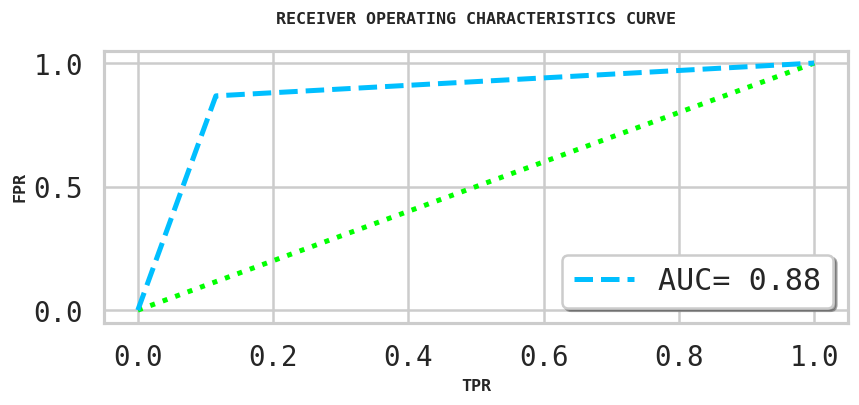





	____________________________________________CONFUSION MATRIX___________________________________________



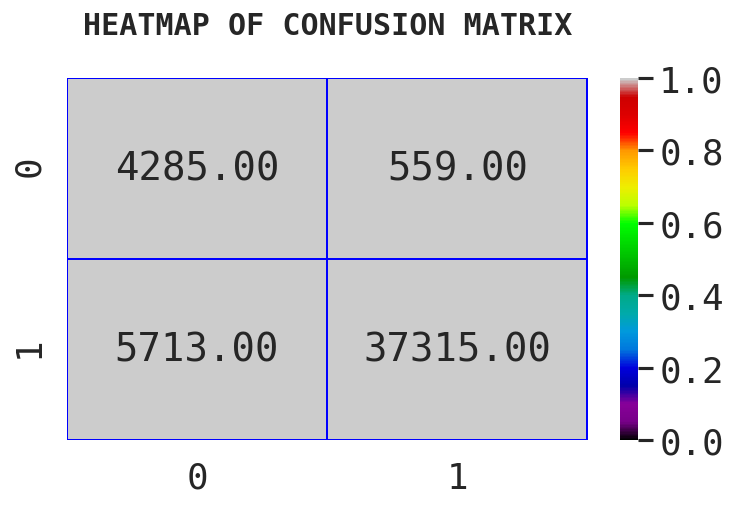

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.585466,0.881559,0.439758,0.875574,0.344152,0.118441,0.878883,4.090887
1,highly_malignant,0.200616,0.934910,0.113300,0.874720,0.255128,0.065090,0.905099,2.248188
2,rude,0.489854,0.903367,0.338825,0.883804,0.310858,0.096633,0.894128,3.337647
3,threat,0.061683,0.941532,0.032303,0.681481,0.241802,0.058468,0.811874,2.019474
4,abuse,0.467448,0.901237,0.317424,0.886373,0.314266,0.098763,0.894187,3.411240
5,loathe,0.155773,0.922564,0.086211,0.806604,0.278273,0.077436,0.865102,2.674594
6,normal,0.922474,0.868984,0.985241,0.867226,0.361961,0.131016,0.875913,4.525143


In [54]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    CNB_pipeline.fit(x_train, y_train[category])
    pred = CNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### LINEAR SVC

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8815591577540107

F1 score: 0.5854657113613102

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     43299
           1       0.44      0.88      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.71      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.4397583745194948

RECALL:
 0.8755740214301334

MEAN SQUARED ERROR:
 0.1184408422459893

ROOT MEAN SQ. ERROR:
 0.3441523532477866

LOG_LOSS: 4.090886967447255

AUC_ROC Score:
 0.8788826480277068

TPR: [0.         0.11780873 1.        ] 
FPR: [0.         0.87557402 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



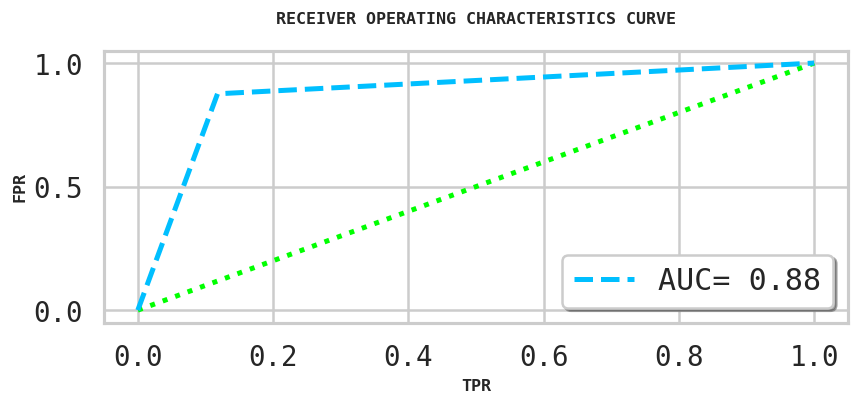





	____________________________________________CONFUSION MATRIX___________________________________________



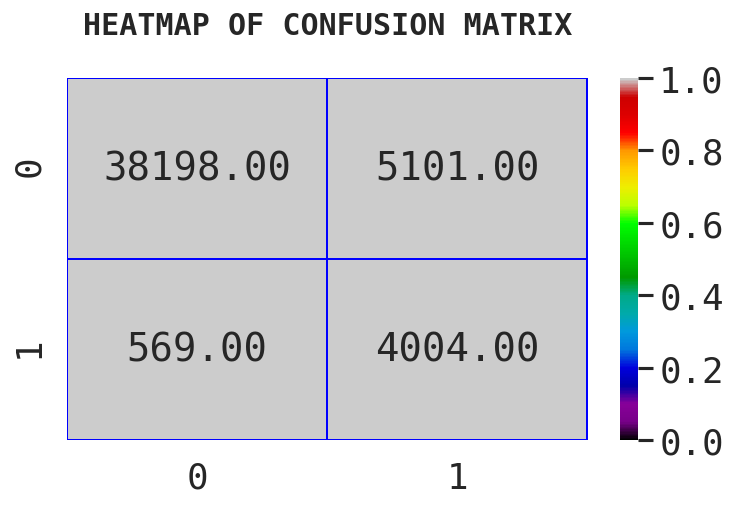



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9349097593582888

F1 score: 0.20061570035915857

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.11      0.87      0.20       447

    accuracy                           0.93     47872
   macro avg       0.56      0.91      0.58     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.11330049261083744

RECALL:
 0.8747203579418344

MEAN SQUARED ERROR:
 0.06509024064171123

ROOT MEAN SQ. ERROR:
 0.2551278907562073

LOG_LOSS: 2.2481883776461835

AUC_ROC Score:
 0.9050987134991195

TPR: [0.         0.06452293 1.        ] 
FPR: [0.         0.87472036 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



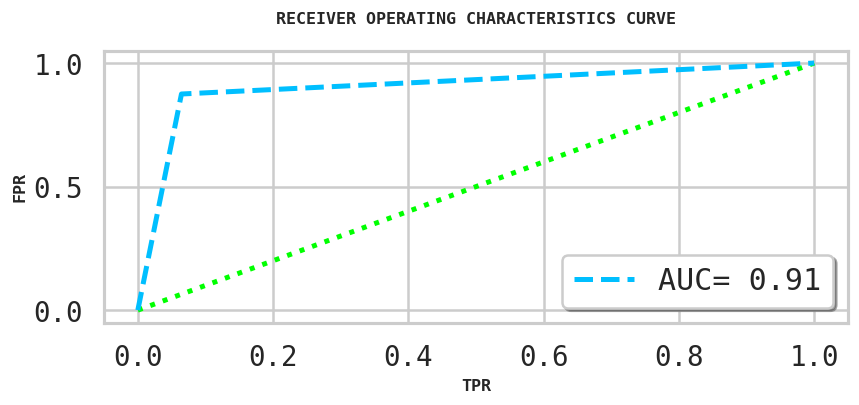





	____________________________________________CONFUSION MATRIX___________________________________________



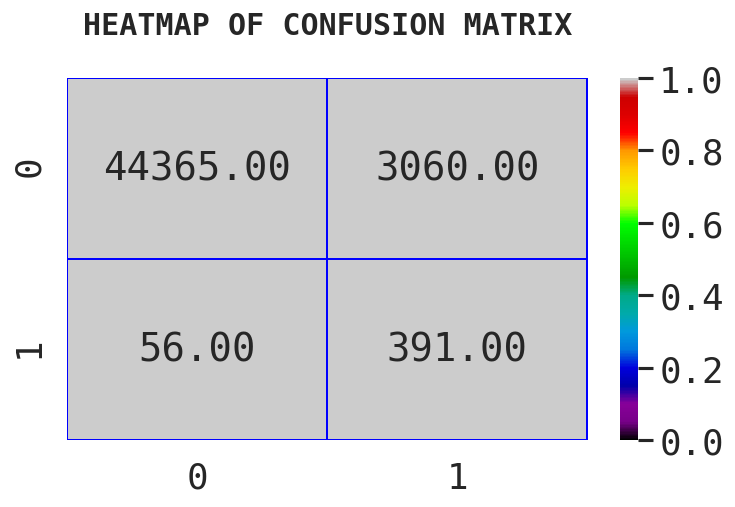



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9033673128342246

F1 score: 0.4898544331715924

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     45359
           1       0.34      0.88      0.49      2513

    accuracy                           0.90     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.33882532418001526

RECALL:
 0.8838042180660565

MEAN SQUARED ERROR:
 0.0966326871657754

ROOT MEAN SQ. ERROR:
 0.3108579855267923

LOG_LOSS: 3.3376471644827728

AUC_ROC Score:
 0.8941276871983316

TPR: [0.         0.09554884 1.        ] 
FPR: [0.         0.88380422 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



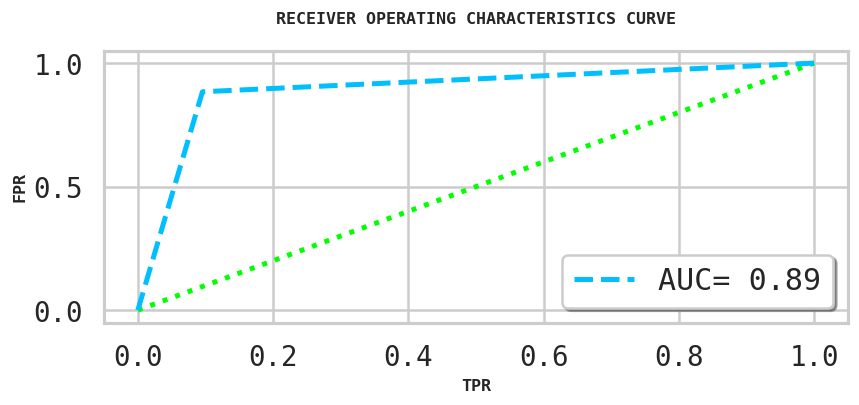





	____________________________________________CONFUSION MATRIX___________________________________________



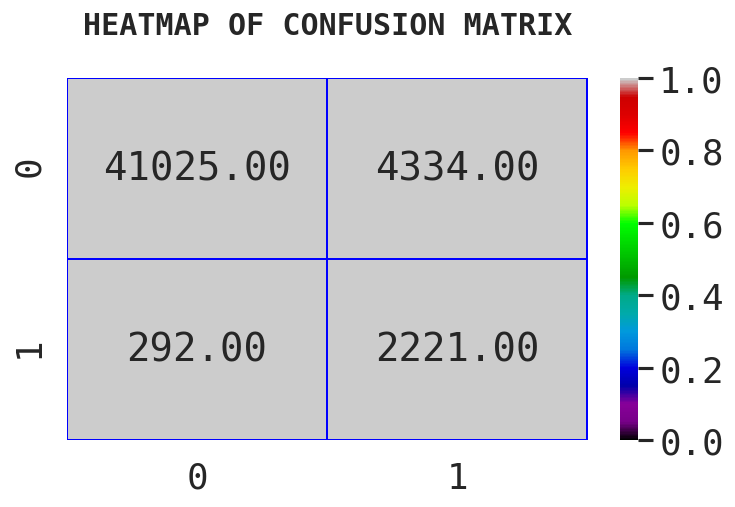



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9415315842245989

F1 score: 0.06168286959436809

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47737
           1       0.03      0.68      0.06       135

    accuracy                           0.94     47872
   macro avg       0.52      0.81      0.52     47872
weighted avg       1.00      0.94      0.97     47872


PRECISION:
 0.032303370786516857

RECALL:
 0.6814814814814815

MEAN SQUARED ERROR:
 0.05846841577540107

ROOT MEAN SQ. ERROR:
 0.24180243128513218

LOG_LOSS: 2.0194735716049603

AUC_ROC Score:
 0.8118742430555071

TPR: [0.       0.057733 1.      ] 
FPR: [0.         0.68148148 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



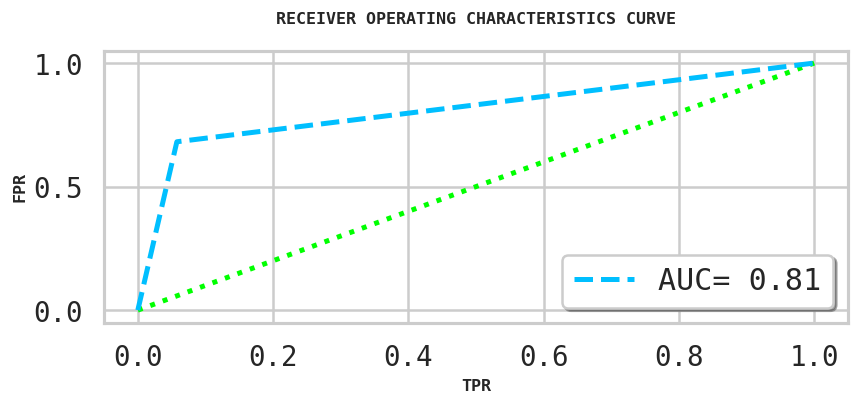





	____________________________________________CONFUSION MATRIX___________________________________________



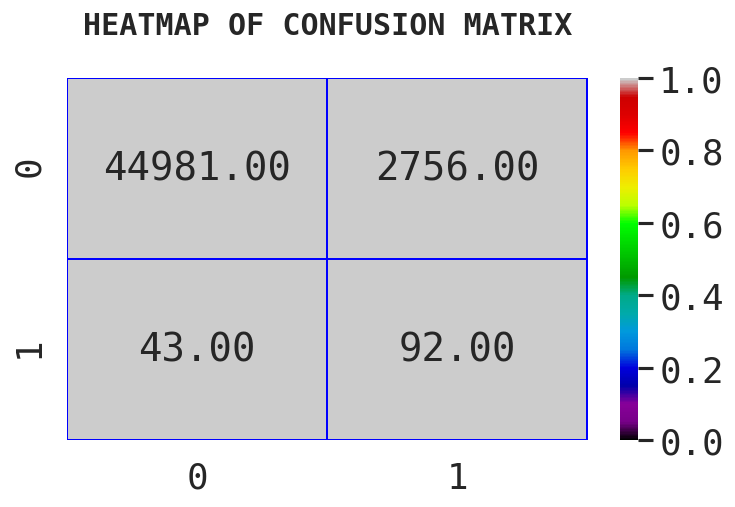



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9012366310160428

F1 score: 0.4674476233385898

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     45531
           1       0.32      0.89      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.3174238947529448

RECALL:
 0.8863733447244767

MEAN SQUARED ERROR:
 0.09876336898395723

ROOT MEAN SQ. ERROR:
 0.31426639811465246

LOG_LOSS: 3.4112404453307

AUC_ROC Score:
 0.894187089660343

TPR: [0.         0.09799917 1.        ] 
FPR: [0.         0.88637334 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



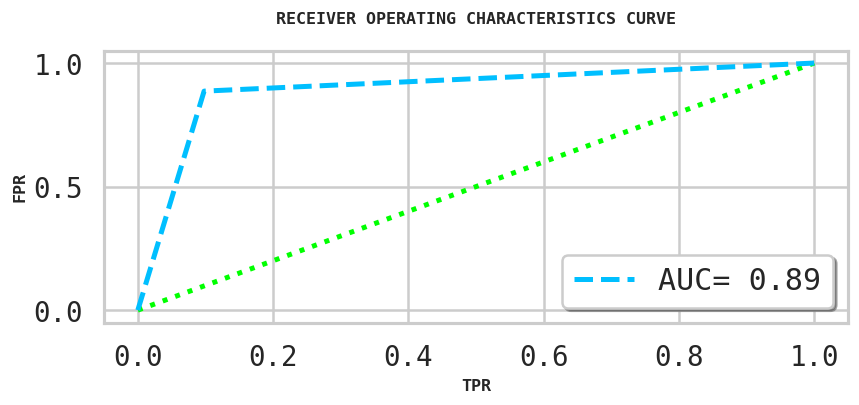





	____________________________________________CONFUSION MATRIX___________________________________________



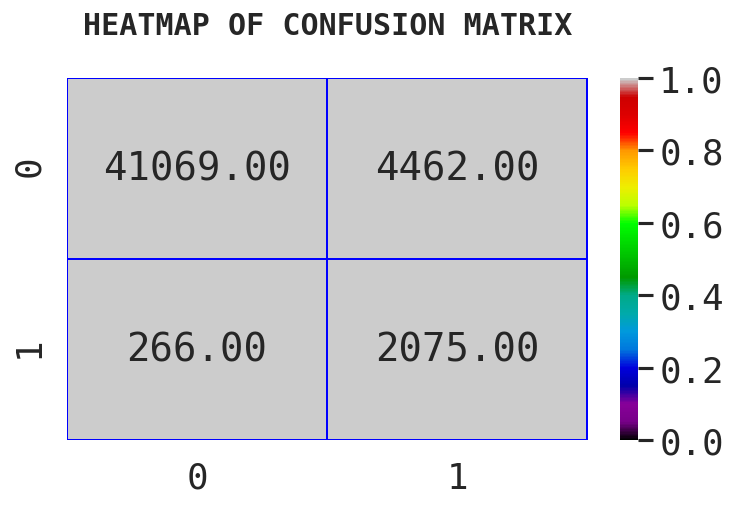



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9225643382352942

F1 score: 0.155773172398087

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     47448
           1       0.09      0.81      0.16       424

    accuracy                           0.92     47872
   macro avg       0.54      0.87      0.56     47872
weighted avg       0.99      0.92      0.95     47872


PRECISION:
 0.08621124275270986

RECALL:
 0.8066037735849056

MEAN SQUARED ERROR:
 0.07743566176470588

ROOT MEAN SQ. ERROR:
 0.2782726392671509

LOG_LOSS: 2.674593554407971

AUC_ROC Score:
 0.8651021734220262

TPR: [0.         0.07639943 1.        ] 
FPR: [0.         0.80660377 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



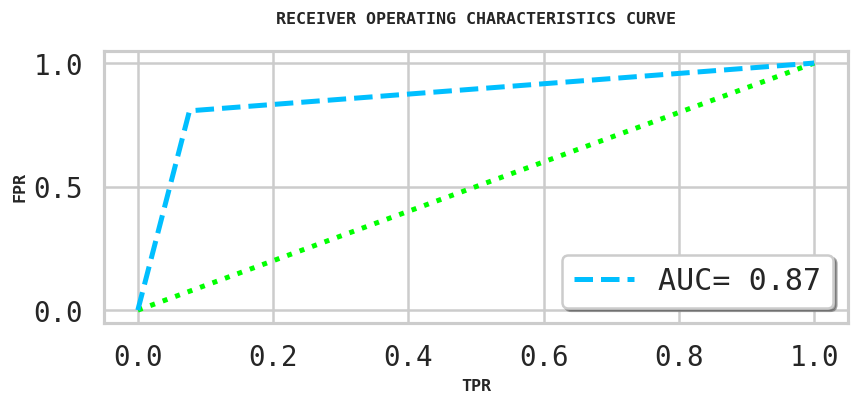





	____________________________________________CONFUSION MATRIX___________________________________________



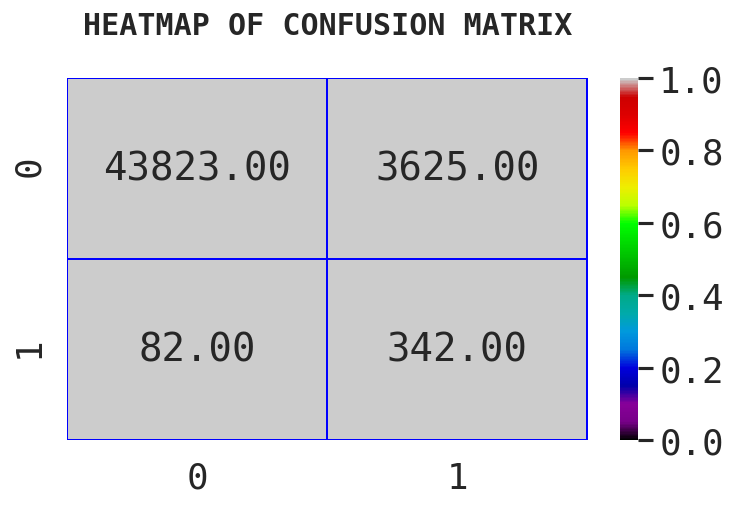



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8689839572192514

F1 score: 0.9224741044720773

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.43      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9852405344035486

RECALL:
 0.8672259923770568

MEAN SQUARED ERROR:
 0.13101604278074866

ROOT MEAN SQ. ERROR:
 0.3619613829965134

LOG_LOSS: 4.525143142627074

AUC_ROC Score:
 0.875912748459379

TPR: [0.        0.1154005 1.       ] 
FPR: [0.         0.86722599 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



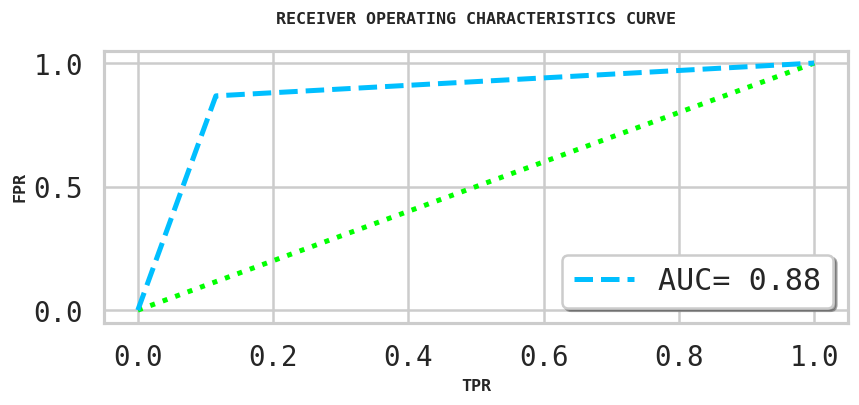





	____________________________________________CONFUSION MATRIX___________________________________________



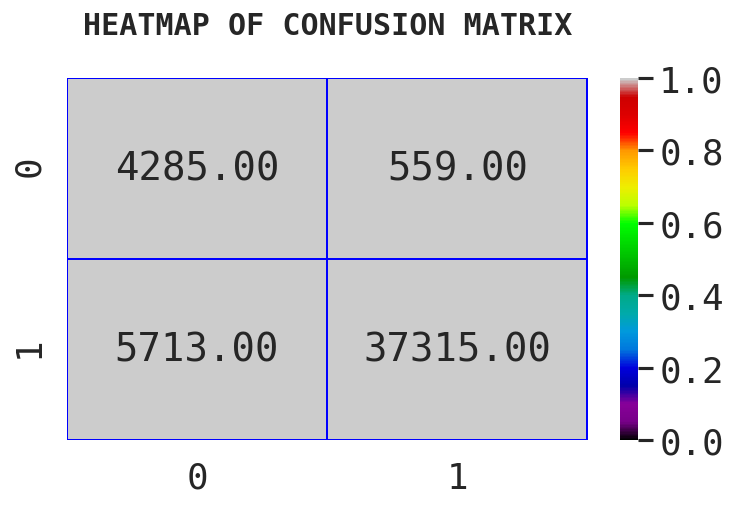

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.585466,0.881559,0.439758,0.875574,0.344152,0.118441,0.878883,4.090887
1,highly_malignant,0.200616,0.934910,0.113300,0.874720,0.255128,0.065090,0.905099,2.248188
2,rude,0.489854,0.903367,0.338825,0.883804,0.310858,0.096633,0.894128,3.337647
3,threat,0.061683,0.941532,0.032303,0.681481,0.241802,0.058468,0.811874,2.019474
4,abuse,0.467448,0.901237,0.317424,0.886373,0.314266,0.098763,0.894187,3.411240
5,loathe,0.155773,0.922564,0.086211,0.806604,0.278273,0.077436,0.865102,2.674594
6,normal,0.922474,0.868984,0.985241,0.867226,0.361961,0.131016,0.875913,4.525143


In [55]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    svc_pipeline.fit(x_train, y_train[category])
    pred = svc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

In [56]:
#printing all the dataframe at one place

print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC\n')
display(lsvc_results)


RESULTS OBTAINED FROM LOGISTIC REGRESSION



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.725203,0.956133,0.902900,0.605948,0.209444,0.043867,0.799533,1.515117
1,highly_malignant,0.295840,0.990454,0.475248,0.214765,0.097705,0.009546,0.606265,0.329719
2,rude,0.748771,0.977586,0.909556,0.636291,0.149713,0.022414,0.816393,0.774153
3,threat,0.143791,0.997264,0.611111,0.081481,0.052311,0.002736,0.540667,0.094514
4,abuse,0.625066,0.970254,0.814688,0.507048,0.172470,0.029746,0.750559,1.027395
5,loathe,0.254753,0.991811,0.656863,0.158019,0.090490,0.008189,0.578641,0.282821
6,normal,0.975889,0.955861,0.958616,0.993795,0.210092,0.044139,0.806352,1.524522



RESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.722794,0.954399,0.861902,0.622349,0.213543,0.045601,0.805909,1.575002
1,highly_malignant,0.353846,0.987717,0.347732,0.360179,0.110828,0.012283,0.676906,0.424236
2,rude,0.753526,0.977001,0.861310,0.669717,0.151654,0.022999,0.831871,0.794356
3,threat,0.317919,0.995070,0.260664,0.407407,0.070213,0.004930,0.702070,0.170272
4,abuse,0.631907,0.965491,0.660456,0.605724,0.185765,0.034509,0.794856,1.191900
5,loathe,0.326750,0.992167,0.684211,0.214623,0.088506,0.007833,0.606869,0.270556
6,normal,0.972163,0.949741,0.967952,0.976411,0.224185,0.050259,0.844626,1.735908



RESULTS OBTAINED FROM MULTINOMIAL NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.646390,0.948028,0.923264,0.497267,0.227974,0.051972,0.746451,1.795050
1,highly_malignant,0.235294,0.989138,0.343348,0.178971,0.104222,0.010862,0.587872,0.375173
2,rude,0.653914,0.971278,0.889726,0.516912,0.169477,0.028722,0.756681,0.992040
3,threat,0.000000,0.994945,0.000000,0.000000,0.071100,0.005055,0.498879,0.174600
4,abuse,0.551066,0.966578,0.802944,0.419479,0.182818,0.033422,0.707093,1.154375
5,loathe,0.113793,0.989263,0.211538,0.077830,0.103619,0.010737,0.537619,0.370844
6,normal,0.971242,0.946984,0.947641,0.996049,0.230253,0.053016,0.753598,1.831160



RESULTS OBTAINED FROM COMPLEMENT NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.585466,0.881559,0.439758,0.875574,0.344152,0.118441,0.878883,4.090887
1,highly_malignant,0.200616,0.934910,0.113300,0.874720,0.255128,0.065090,0.905099,2.248188
2,rude,0.489854,0.903367,0.338825,0.883804,0.310858,0.096633,0.894128,3.337647
3,threat,0.061683,0.941532,0.032303,0.681481,0.241802,0.058468,0.811874,2.019474
4,abuse,0.467448,0.901237,0.317424,0.886373,0.314266,0.098763,0.894187,3.411240
5,loathe,0.155773,0.922564,0.086211,0.806604,0.278273,0.077436,0.865102,2.674594
6,normal,0.922474,0.868984,0.985241,0.867226,0.361961,0.131016,0.875913,4.525143



RESULTS OBTAINED FROM LINER SVC



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.585466,0.881559,0.439758,0.875574,0.344152,0.118441,0.878883,4.090887
1,highly_malignant,0.200616,0.934910,0.113300,0.874720,0.255128,0.065090,0.905099,2.248188
2,rude,0.489854,0.903367,0.338825,0.883804,0.310858,0.096633,0.894128,3.337647
3,threat,0.061683,0.941532,0.032303,0.681481,0.241802,0.058468,0.811874,2.019474
4,abuse,0.467448,0.901237,0.317424,0.886373,0.314266,0.098763,0.894187,3.411240
5,loathe,0.155773,0.922564,0.086211,0.806604,0.278273,0.077436,0.865102,2.674594
6,normal,0.922474,0.868984,0.985241,0.867226,0.361961,0.131016,0.875913,4.525143


```basing on the above results using  LOGISTIC REGESSION   as final model```

In [57]:
LogReg_pipeline

Pipeline(memory=None,
         steps=[('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                                                                  max_iter=100,
                                                                  multi_class='auto',
                                                                  n_jobs=None,
                                                                  penalty='l2',
                                                                  random_state=None,
                                                      

In [58]:
joblib.dump(LogReg_pipeline,'COMMENT_LOGI.pkl')

['COMMENT_LOGI.pkl']

In [59]:
#loading the model
model=joblib.load('COMMENT_LOGI.pkl')

In [60]:
test.head(7)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl
5,Thank you for understanding. I think very high...,thank think highli revert discuss
6,Please do not add nonsense to Wikipedia. Such ...,pleas add nonsens wikipedia edit consid vandal...


In [61]:
X=test['comment']
X

0         bitch rule succes ever hate sad mofuckasi bitc...
1                                         rfc titl fine imo
2                                  sourc zaw ashton lapland
3         look sourc inform updat correct form guess sou...
4                                        anonym edit articl
                                ...                        
153159                    total agre stuff noth toolongcrap
153160    throw field home plate faster throw cut man di...
153161    categori chang agre correct gotten confus foun...
153162    one found nation germani law return quit simil...
153163    stop alreadi bullshit welcom fool think kind e...
Name: comment, Length: 153164, dtype: object

In [65]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=8000,ngram_range=(1,3))
test_x=tfidf.fit_transform(X)

In [66]:
test_x.shape

(153164, 8000)

In [67]:
result=model.predict(test_x)

In [68]:
display(result)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)